# Implementing Linear Regression from Scratch

## Introduction
This project arose from a desire to practice and implement my newly acquired skills in Machine Learning. My understanding of these skills was honed through **Andrew Ng's acclaimed Supervised Learning course on Coursera**. With a solid grasp of the underlying calculus and newfound knowledge about different algorithms and concepts, I felt equipped and ready to put these principles into action by implementing a classic Machine Learning algorithm -- **linear regression**.

The objective was straightforward yet challenging, to build a linear regression model entirely from scratch, implementing foundational algorithms such as **gradient descent** along the way. The project served as a fun playground to test out my theoretical knowledge in a practical setting, and to enjoy the thrill of seeing a mathematical model come alive.

Keep in mind that contrary to the usual approach of identifying a problem first and then choosing an appropriate algorithm to solve it, the goal of this project was to practice implementing a pre-selected algorithm, linear regression, as a learning experience. With that in mind, I worked backwards and looked for a very large dataset that should work well with linear regression algorithm. The data set chosen for this project is a comprehensive collection of taxi rides in New York City, [available on Kaggle here](https://www.kaggle.com/competitions/new-york-city-taxi-fare-prediction/data).

In the following sections, I will guide you through the different stages I undertook in the developing of this model, from pre-processing the data and implementing the algorithms to training the model and evaluating its performance.

Join me on this exciting journey as I build my **first machine learning model from scratch**, and witness the beauty and magic where calculus meets computer science.

In [34]:
import pandas as pd  # data handling
import numpy as np  # math (linear algebra)
import matplotlib.pyplot as plt  # plotting data

# machine learning workflow
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

## Data Loading and Inspection
We're using a data set of taxi rides in New York City and we're trying to predict the cost of the trips. The dataset is originally nearly 55.5 million rows, which is massive 😳 So to make things much easier to handle, I picked a random sample of 1.3 million rows to work with; 1mil for training and 0.3mil for testing. Below I import the data and perform important inspection of the data where I see what features we have, the ranges of some of these features, etc.

In [35]:
# load dataset and explore it
dataset = pd.read_csv('ny_taxi_fares_dataset_chunk.csv')

# analyze the dataset's shape, first few rows, features, means/summary, and more.
print('Shape:')
print(dataset.shape, end='\n\n')

print('Columns:')
print(', '.join(dataset.columns), end='\n\n')

print('Head:')
print(dataset.head(), end='\n\n')

print('Info:')
print(dataset.info(), end='\n\n')

print('Describe:')
print(dataset.describe(), end='\n\n')

print('Null Count:', dataset.isnull().sum(), end='\n\n')

Shape:
(1300000, 8)

Columns:
key, fare_amount, pickup_datetime, pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude, passenger_count

Head:
                             key  fare_amount          pickup_datetime   
0  2010-09-15 20:03:00.000000195         12.5  2010-09-15 20:03:00 UTC  \
1    2010-02-19 13:32:37.0000003          5.7  2010-02-19 13:32:37 UTC   
2    2015-05-24 13:21:59.0000007         11.0  2015-05-24 13:21:59 UTC   
3    2013-07-15 19:48:38.0000001         12.5  2013-07-15 19:48:38 UTC   
4    2014-06-18 22:12:13.0000002         10.5  2014-06-18 22:12:13 UTC   

   pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude   
0        -74.005988        40.741215         -74.015480         40.714537  \
1        -74.013270        40.715096         -74.012666         40.702455   
2        -73.948174        40.782948         -73.975395         40.752914   
3        -73.985779        40.758557         -73.974966         40.790157   
4        -

The dataset analysis above allows us to actually get a grasp of the data we're looking at and understand how some of the datapoints may look. We also get to see the **features**, or inputs we're working with. The `describe` method revealed to me the wide variety of ranges of the different features, with the passenger count ranging from 0 to 20, while the pickup latitude ranging from -3442 to 3361. This tells us we're going to need to scale the features, otherwise the difference in ranges will have a terrible impact on gradient descent in terms of performance, and will make it difficult to even reach an acceptable minimum. We'll also have to deal with outliers and possible false values, because for example, the passenger count goes up to 20 and last I checked, taxis can't carry 20 people.

Below are the columns/features we pulled from the dataset.

### Features
- fare_amount **(target value)**: float dollar amount of the cost of the taxi ride.
- pickup_datetime: timestamp value indicating when the taxi ride started.
- pickup_longitude: float for longitude coordinate of where the taxi ride started.
- pickup_latitude: float for latitude coordinate of where the taxi ride started.
- dropoff_longitude: float for longitude coordinate of where the taxi ride ended.
- dropoff_latitude: float for latitude coordinate of where the taxi ride ended.
- passenger_count: integer indicating the number of passengers in the taxi ride.

## Data Preprocessing
This is where a lot of work is going to be before we can get to any fun math. During the **data inspection** stage, we revealed many odd values like negative coordinates and trips with 20 passenger, which is what we aim to fix in this stage.

First as a more general step, we cut off the key column and drop the rows with null values.

In [36]:
# drop "key ID" column, then drop null rows
dataset = dataset.drop('key', axis=1)
dataset.dropna(inplace=True)

### Preprocessing the Target Values
To preprocess the target values we're going filter the target `fare_amount` to remove extreme outliers. This involves setting a maximum acceptable value (high threshold) and a minimum threshold based on the 1st percentile of fare data (low threshold). We then filter the dataset to remove rows outside of this range and only include fares within this range.

This helps make our model more robust by limiting the influence of extreme fare values, as well as removing clearly false negative prices. After this filtering process, we check the new minimum and maximum fare_amount values to confirm that our filtering operation was successful.

Min fare_amount before filtering: -45.0
Max fare_amount before filtering: 500.0
High threshold:  100
1st percentile:  3.3
Min fare_amount after filtering: 3.3
Max fare_amount after filtering: 100.0


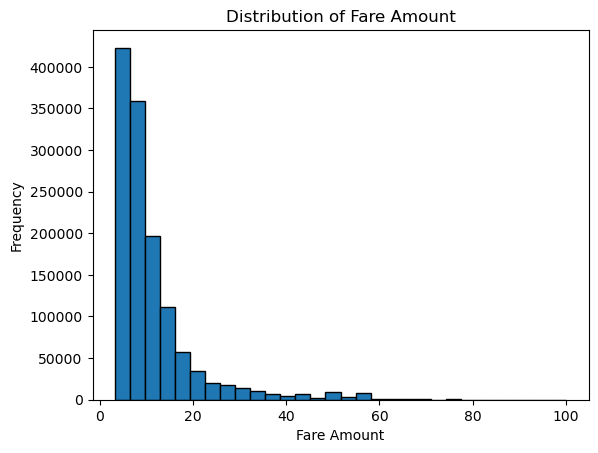

In [37]:
# check the min and max before filtering
print('Min fare_amount before filtering:', dataset['fare_amount'].min())
print('Max fare_amount before filtering:', dataset['fare_amount'].max())

# set a fixed high threshold
high_threshold = 100
print('High threshold: ', high_threshold)

# calculate 1st percentile-based low threshold
low_threshold = dataset['fare_amount'].quantile(0.01)
print('1st percentile: ', low_threshold)

# filter based on the thresholds
dataset = dataset[dataset['fare_amount'] <= high_threshold]
dataset = dataset[dataset['fare_amount'] >= low_threshold]

# check the min and max after filtering
print('Min fare_amount after filtering:', dataset['fare_amount'].min())
print('Max fare_amount after filtering:', dataset['fare_amount'].max())

# plot the distribution of fare_amount to see how the shape has improved
plt.hist(dataset['fare_amount'], bins=30, edgecolor='black')
plt.title('Distribution of Fare Amount')
plt.xlabel('Fare Amount')
plt.ylabel('Frequency')
plt.show()

### Preprocessing the Features
To preprocess the features, we'll visualize each feature using both histograms and boxplots. These plots provide valuable insight into the distribution of each feature and allow us to identify any potential outliers. This allows us to evaluate what outlier treatment might be necessary to better prepare our data for model training.

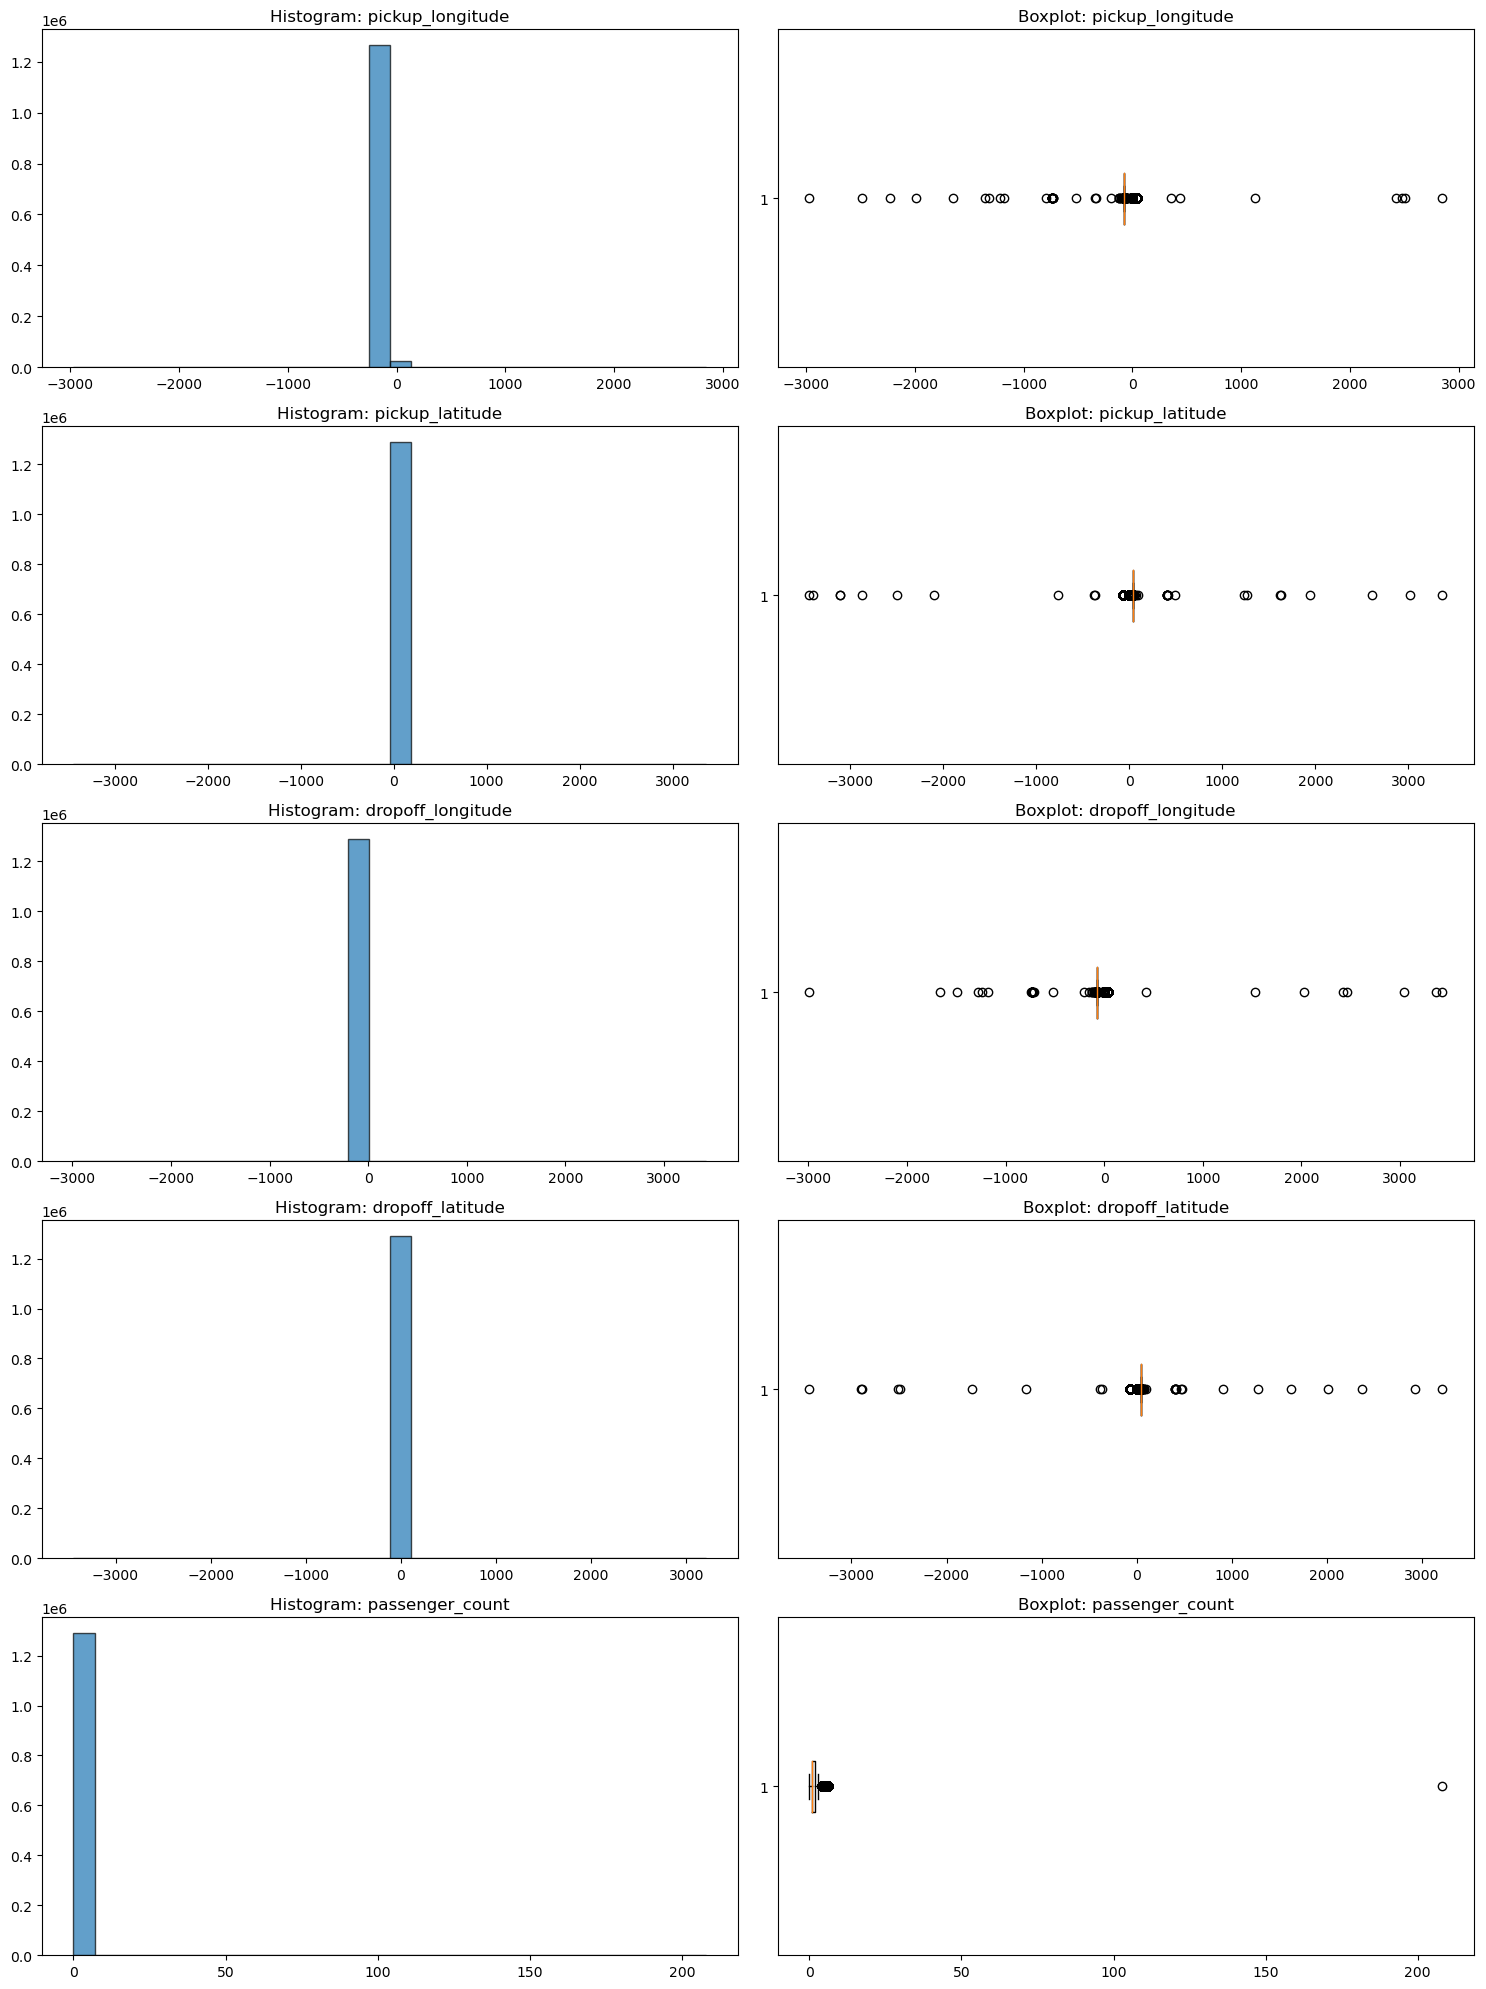

In [38]:
# we plot each feature's data in a histogram and boxplot
# to analyze the features for outlier treatment

feature_names = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count']

fig, axs = plt.subplots(len(feature_names), 2, figsize=(15, 4*len(feature_names)))

# iterate through every feature and plot their data
for i, feature in enumerate(feature_names):
    # histogram
    axs[i][0].hist(dataset[feature], bins=30, edgecolor='black', alpha=0.7)
    axs[i][0].set_title(f'Histogram: {feature}')

    # boxplot
    axs[i][1].boxplot(dataset[feature].dropna(), vert=False)  # dropna() is used in case there are any NaN values
    axs[i][1].set_title(f'Boxplot: {feature}')

plt.tight_layout()
plt.show()


Based on what we've seen in the boxplots and histograms, we filter the passenger count and pickup longitude & latitude to cut off the extreme values. We also convert the pickup_datetime from a string to a datetime object, because it wouldn't mean anything as a string.

In [39]:
# filter out passenger counts higher than 10
dataset = dataset[dataset['passenger_count'] <= 10]

# filter the pickup longitudes and latitudes using fixed thresholds
dataset = dataset[(dataset['pickup_longitude'] >= -750) & (dataset['pickup_longitude'] <= 200)]
dataset = dataset[(dataset['pickup_latitude'] >= -500) & (dataset['pickup_latitude'] <= 550)]

# convert pickup_datetime from string to datetime
dataset['pickup_datetime'] = pd.to_datetime(dataset['pickup_datetime'])

## Feature Engineering!
Feature engineering is one of my most favorite parts, as the idea of combining distinct features to generate more meaningful data is quite intriguing.

First, we're going to turn the datetime column into more useful features, because the linear regression model needs values in the form of numbers. Out of all the information in a datetime, the day_of_week and the hour_of_day seem the most useful as they should have the most influence on taxi fares (ex. more taxis on a Friday night).

On another note, this dataset unfortunately doesn't contain trip distances, which I believe would be most strongly correlated with the taxi price. What we do have is the pickup and dropoff coordinates in longitude and latitude, so we can calculate the Euclidean distance and add that as a feature. The problem is that the Euclidean distance is essentially a straight line between two points, which is not an accurate reflection of the actual trip distance for a taxi ride. This is due to the realities of city navigation - taxis must follow roads and traffic patterns, which can lead to routes that deviate considerably from a straight-line path. Nevertheless, this is the best we can do without the true trip distance, and maybe Euclidean distance will have at least some small influence towards a more accurate prediction.

In [40]:
# create day_of_week and hour_of_day features (0 is Monday, 6 is Sunday)
dataset['day_of_week'] = dataset['pickup_datetime'].dt.dayofweek
dataset['hour_of_day'] = dataset['pickup_datetime'].dt.hour
dataset = dataset.drop('pickup_datetime', axis=1)  # drop the original pickup_datetime feature

# add the Euclidean distance as a feature
dataset['euclidean_distance'] = np.abs(np.sqrt((dataset['pickup_longitude'] - dataset['dropoff_longitude'])**2 
                               + (dataset['pickup_latitude'] - dataset['dropoff_latitude'])**2))

# add new features
feature_names.extend(['day_of_week', 'hour_of_day', 'euclidean_distance'])
# distance outliers
# dataset = dataset[dataset['euclidean_distance'] <= 1000] !

In [41]:
print('first few rows of the data after feature engineering')
dataset.head()

first few rows of the data after feature engineering


,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,day_of_week,hour_of_day,euclidean_distance
0,12.5,-74.005988,40.741215,-74.015480,40.714537,1,2,20,0.028316
1,5.7,-74.013270,40.715096,-74.012666,40.702455,1,4,13,0.012655
2,11.0,-73.948174,40.782948,-73.975395,40.752914,1,6,13,0.040534
3,12.5,-73.985779,40.758557,-73.974966,40.790157,1,0,19,0.033399
4,10.5,-73.968955,40.754464,-73.997979,40.729139,1,2,22,0.038519


## Data Preparation
Now that our raw data has undergone various stages of data processing, we can prepare it for modeling. The most important data preparation step is splitting the dataset into training and testing data.

In [42]:
# split data
y = dataset['fare_amount']
X = dataset.drop('fare_amount', axis=1)

                    # ~0.3 million rows / ~1.3 million total rows = 0.233
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.233, random_state=42)

### Feature Scaling
One processing step we couldn't perform earlier is **feature scaling**, because it needs to be applied after we've split our dataset into training and testing data.

The reason behind this order is to prevent **information leakage** from the test set into training set. When we calculate scaling parameters using the entire dataset, we run the risk of incorporating knowledge from the test set. This could lead to overoptimistic performance and a skewed model evaluation.

Hence, it's crucial to perform the train-test split before undertaking any feature scaling. By doing so, we ensure that our scaling parameters are derived solely from the training data, thereby preserving the integrity of our testing process.

In [43]:
# feature scaling
scaler = MinMaxScaler()

# fit the scale based on the training data (avoids leakage)
# then transform both the train and testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# convert scaled training data to pandas dataframe for analysis
scaled_df = pd.DataFrame(X_train_scaled, columns=feature_names)
print(scaled_df.describe())

       pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude   
count     988376.000000    988376.000000      988376.000000     988376.000000  \
mean           0.854487         0.523703           0.469758          0.113507   
std            0.013524         0.007946           0.003591          0.001944   
min            0.000000         0.000000           0.000000          0.000000   
25%            0.852609         0.524740           0.469280          0.113728   
50%            0.852622         0.524763           0.469284          0.113734   
75%            0.852641         0.524781           0.469289          0.113738   
max            1.000000         1.000000           1.000000          1.000000   

       passenger_count    day_of_week    hour_of_day  euclidean_distance  
count    988376.000000  988376.000000  988376.000000       988376.000000  
mean          0.280980       0.506659       0.587568            0.000063  
std           0.218229       0.324814       0

After feature scaling, we can see that our ranges are significantly smaller and more similar to each other. This normalization improves the efficiency of the gradient descent optimization process in our linear regression model. With features on a similar scale, the path of gradient descent is more direct and less likely to oscillate, allowing it to converge to the minimum more quickly and accurately. Essentially, feature scaling enhances the algorithm's performance and speed, providing a more reliable and efficient learning process.

## Model Building
At last we've reached the model building stage, there won't be any more data preprocessing/preparation. This is the stage where we put the machine learning concepts we've been discussing into practice. The objective of this stage is to implement a linear regression model using gradient descent from scratch. We will use mini-batch gradient descent, because unfortunately we have far too many rows to use regular batch gradient descent.

### Linear Regression
Linear regression is a fundamental algorithm in supervised learning that predicts a target variable (fare_amount) by fitting the best linear relationship between the target and feature variables (hour_of_day, pickup_longitude, etc.). Linear regression achieves this "best fit" by minimizing a measure of the error (sum of the squared differences) between the actual and predicted values; the measure of the error is called the cost, calculated using the **cost function**.

The iterative process used to minimize the cost function is called **gradient descent**. We start with random values for the coefficients (parameters), and then iteratively update these values, moving them down the gradient of the cost function. The process continues until we converge to the minimum of the function, hence achieving the optimal parameters for our linear regression model.

### The Math Behind It
While I won't delve into nitty-gritty, it's important to note that these equations are key to this implementation. Therefore, I'll present them below for your reference, as they form the mathematical foundation of the work ahead.

Linear model: $ f_{\mathbf{w},b}(\mathbf{x}) =  w_0x_0 + w_1x_1 +... + w_{n-1}x_{n-1} + b$

or in vector notation (which is what we will be using): $ f_{\mathbf{w},b}(\mathbf{x}) = \mathbf{w} \cdot \mathbf{x} + b$

Note that $\mathbf{w}$ (parameters) and $\mathbf{x}^{(i)}$ (one row's features) are vectors

Cost function: $J(\mathbf{w},b) = \frac{1}{2m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)})^2$

- ${m}$ is the number of training examples in the data set

Gradient descent:
$$\begin{align*}
\text{repeat}&\text{ until convergence:} \; \lbrace \newline\;
& w_j = w_j -  \alpha \frac{\partial J(\mathbf{w},b)}{\partial w_j} \tag{5}  \; & \text{for j = 0..n-1}\newline
&b\ \ = b -  \alpha \frac{\partial J(\mathbf{w},b)}{\partial b}  \newline \rbrace
\end{align*}$$

To compute the gradient above:
$$\begin{align}
\frac{\partial J(\mathbf{w},b)}{\partial w_j}  &= \frac{1}{k} \sum\limits_{i = 0}^{k-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)})x_{j}^{(i)} \tag{6}  \\
\frac{\partial J(\mathbf{w},b)}{\partial b}  &= \frac{1}{k} \sum\limits_{i = 0}^{k-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)}) \tag{7}
\end{align}$$

- ${k}$ is the defined batch size (instead of using all ${m}$ rows to compute the gradient)

- $f_{\mathbf{w},b}(\mathbf{x}^{(i)})$ is the model's prediction, while $y^{(i)}$ is the target value

### Implementation

In [44]:
class Model:
    def __init__(self, training_examples, targets, alpha=0.01, epsilon=0.001):
        # features and targets
        self.m = training_examples.shape[0]
        self.n = training_examples.shape[1]
        self.training_examples = training_examples
        self.targets = targets
        
        # initialize the parameters to random values
        self.theta_0 = np.random.uniform(-1, 1)  # bias parameter (scalar)
        self.theta_vector = np.random.randn(self.n)  # vector of parameters

        # keeps track of the cost as iterations of gradient descent are applied
        self.cost_history = []
        
        # learning rate and convergence threshold
        self.alpha = alpha
        self.epsilon = epsilon

    def predict(self, training_example):
        """ Makes a prediction based on the given feature inputs. """
        return self.theta_0 + np.dot(training_example, self.theta_vector)

    """ UNVECTORIZED COST FUNCTION
        
        total = 0

        # loop through the training examples and sum each one's squared error
        for example, target in zip(self.training_examples, self.targets):
            prediction = self.predict(example)
                            # (h(x)-y)^2
            total += (prediction - target)**2
            
        return total / (2*self.m) """
    
    def cost(self):
        """ Vectorized cost function, calculated on all the training examples. """
        predictions = self.predict(self.training_examples)
        errors = predictions - self.targets
        return np.sum(errors**2) / (2*self.m)

    def compute_gradient(self, start: int, end: int):
        """ Computes the gradient for the feature parameter vector and bias parameter. """

        # initialize gradient for parameter vector and bias parameter to zero
        vector_gradient = np.zeros((self.n))
        th0_gradient = 0
        
        # iterates through the given range of training rows
        for i in range(start, end):
            example, target = self.training_examples[i], self.targets[i]  # grabs feature row and target
            cost = self.predict(example) - target  # makes prediction and computes cost

            # add the cost to the respective gradient sums
            vector_gradient += cost * example
            th0_gradient += cost
        
        # average the gradient sums by the number of total training examples
        vector_gradient /= self.m
        th0_gradient /= self.m

        return vector_gradient, th0_gradient

    def shuffle_dataset(self):
        """ Shuffles the dataset to ensure randomness every mini-batch epoch. """
        
        # create an array of indices from 0 to the size of the data
        indices = np.arange(self.training_examples.shape[0])
        
        # shuffle this array of indices
        np.random.shuffle(indices)
        
        # use the shuffled indices to reposition the training data and targets
        self.training_examples = self.training_examples[indices]
        self.targets = self.targets[indices]

    def gradient_descent(self, batch_size: int = None):
        """ Gradient descent (batch, mini-batch, or stochastic depending the given batch size). """

        # vanilla batch gradient descent if no batch size is specified
        if batch_size is None:
            batch_size = self.m
            
        iteration = 0  # steps of gradient descent performed
        index = 0  # position in the training set (for mini-batch)
        
        last_cost = float('inf')
        current_cost = self.cost()
        
        # initialize cost plot
        plt.figure(figsize=(10, 6))
        plt.title('Cost Function vs. Iteration')
        plt.xlabel('Iterations')
        plt.ylabel('Cost')
        
        # while progress is greater than epsilon (convergence threshold), perform a step of gradient descent
        while abs(last_cost - current_cost) > self.epsilon:
            # computes the cost every 1000 iterations because it's an expensive operation
            for _ in range(500):
                iteration += 1
                
                # if range is over, skip iteration, go back to start, and shuffle dataset (one epoch)
                if index+batch_size > self.m:
                    index = 0
                    self.shuffle_dataset()
                    continue
                
                # compute gradient and update parameters (take a step of gradient descent)
                gradient, th0_grad = self.compute_gradient(index, index+batch_size)
                self.theta_0 -= self.alpha * th0_grad
                self.theta_vector -= self.alpha * gradient

                # increment index by batch size
                index = (index + batch_size) % self.m
            
            # set current cost to last cost and calculate new current cost
            last_cost = current_cost
            current_cost = self.cost()
            
            print('iteration, index:', iteration, index)
            self.cost_history.append(current_cost)  # save cost
            plt.plot(self.cost_history)
            plt.show()

            print('cost went', 'UP:' if current_cost >= last_cost else 'down:', current_cost)
            print('difference:', abs(current_cost-last_cost))
        
        return self.cost_history
    
    def batch_gradient_descent(self):
        """ Performs default batch gradient descent (uses the whole training set per step). """
        return self.gradient_descent()

    def mini_batch_gradient_descent(self, batch_size: int = 1500):
        """ Performs mini-batch gradient descent given the batch size. """
        return self.gradient_descent(batch_size=batch_size)

    def stochastic_gradient_descent(self):
        """ Performs stochastic gradient descent (essentially batch size of 1). """
        return self.gradient_descent(batch_size=1)

    def train(self, gradient_descent_alg):
        return gradient_descent_alg()

## Model Training
Now that we've prepared our data and built our model, it's time for arguably the most crucial step: Model Training.

We begin by setting our model's hyper parameters: the learning rate, denoted as alpha $\alpha$, and the convergence threshold, epsilon $\varepsilon$. The learning rate alpha regulates the step size our gradient descent algorithm takes when descending the cost function. Epsilon, in contrast, serves as our defined threshold that signals sufficient convergence of our model parameters. Training halts once the rate of descent dips below this specified threshold, indicating that further improvement would be minimal and perhaps unnecessary, unless we adjust our hyperparameters (mainly alpha).

Given the substantial size of our dataset, using all rows for every step of gradient descent is very computationally expensive. Therefore, we resort to mini-batch gradient descent, which uses a subset of the data to calculate the gradient at each step. You might notice that when we defined gradient descent mathematically above, we used a batch size of ${k}$. This approach provides a balance - it will take a less direct path down the gradient, but it's significantly faster than using the full batch while still ensuring a reasonable estimation of the gradient, leading to steady learning progress.

Once these parameters are set, we feed our training data into the model, and the learning journey commences. The model adjusts its parameters iteratively, seeking to minimize the cost function and, by extension, improve its predictive capability.

iteration, index: 500 750000


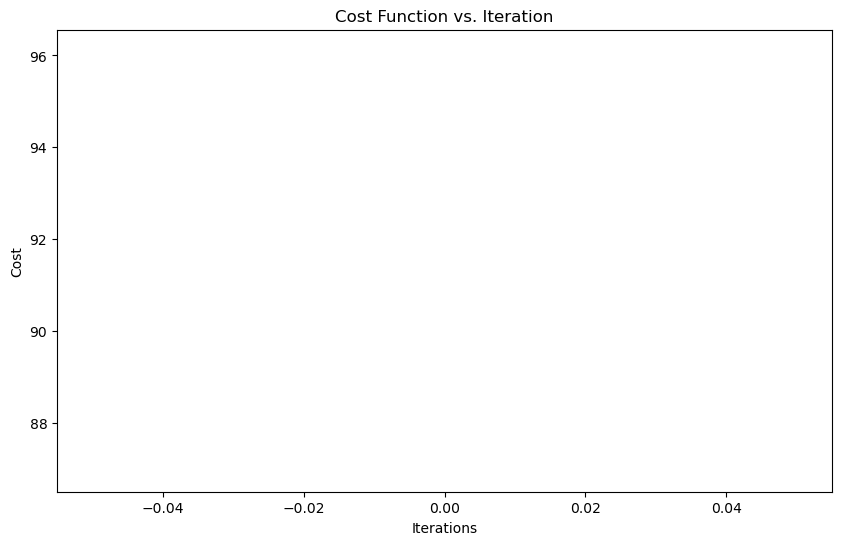

cost went down: 91.52589412682786
difference: 1128.605176368702
iteration, index: 1000 511500


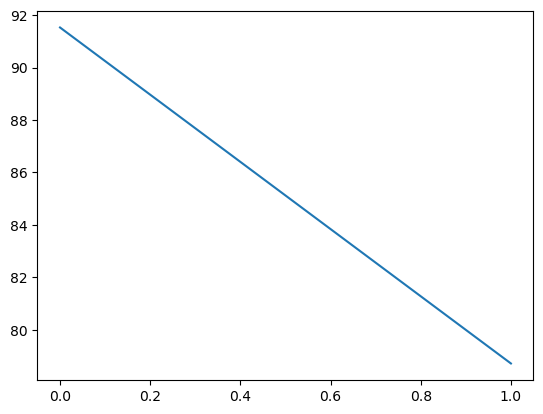

cost went down: 78.71907796738599
difference: 12.80681615944188
iteration, index: 1500 273000


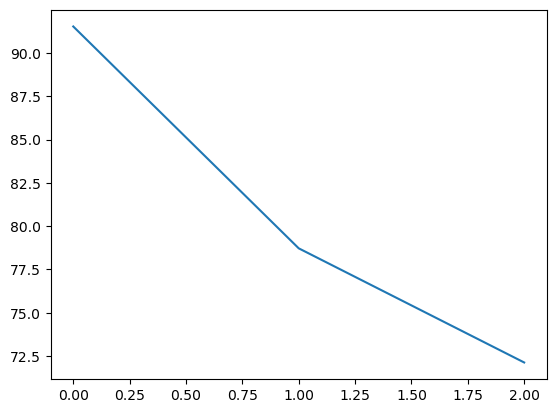

cost went down: 72.12939110213517
difference: 6.589686865250812
iteration, index: 2000 34500


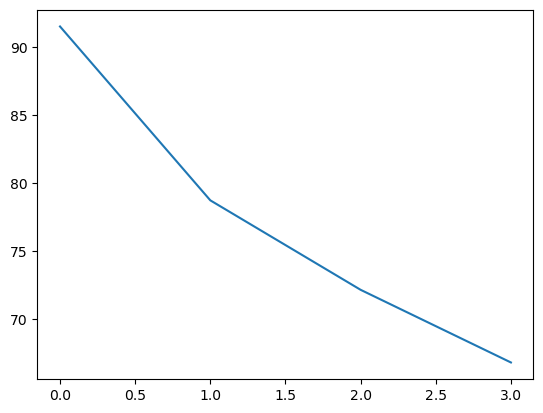

cost went down: 66.77725550163663
difference: 5.352135600498542
iteration, index: 2500 784500


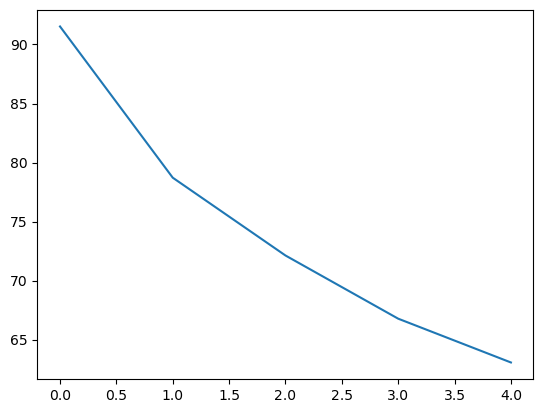

cost went down: 63.06817391172037
difference: 3.7090815899162592
iteration, index: 3000 546000


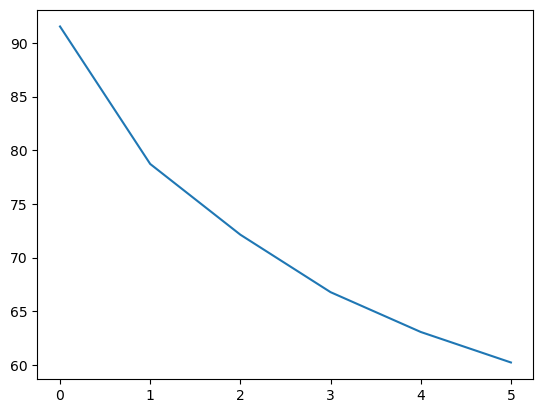

cost went down: 60.2268953425295
difference: 2.8412785691908695
iteration, index: 3500 307500


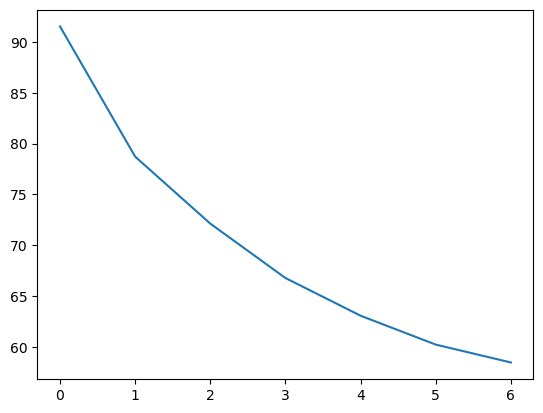

cost went down: 58.46926478475625
difference: 1.757630557773254
iteration, index: 4000 69000


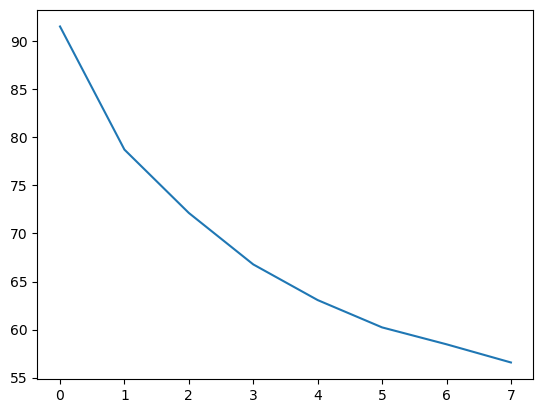

cost went down: 56.5782904327759
difference: 1.890974351980347
iteration, index: 4500 819000


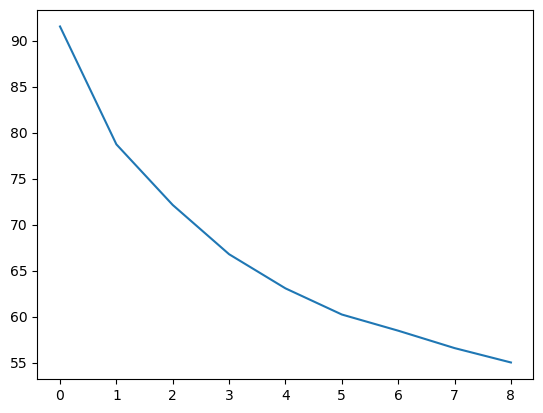

cost went down: 55.01544812467625
difference: 1.562842308099654
iteration, index: 5000 580500


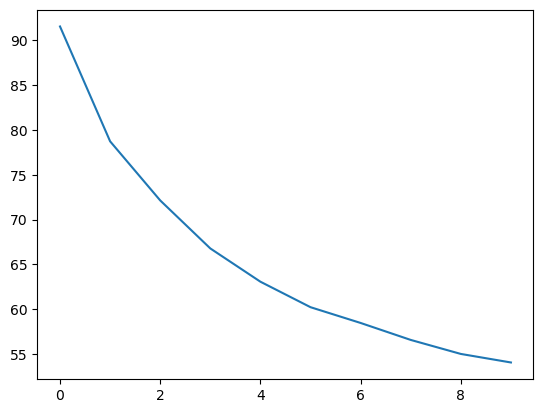

cost went down: 54.06339467944536
difference: 0.952053445230888
iteration, index: 5500 342000


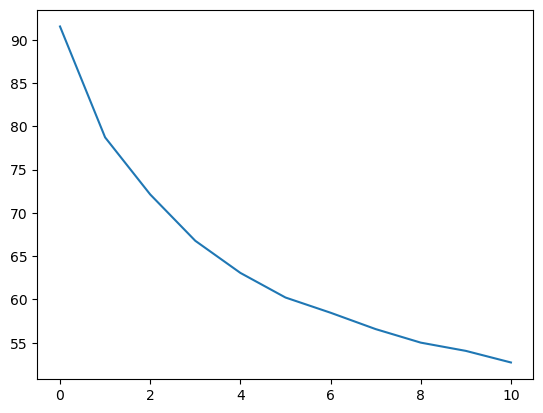

cost went down: 52.72409668731919
difference: 1.3392979921261698
iteration, index: 6000 103500


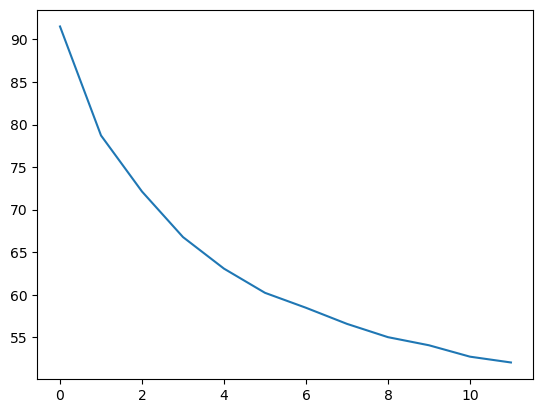

cost went down: 52.04067846998551
difference: 0.6834182173336814
iteration, index: 6500 853500


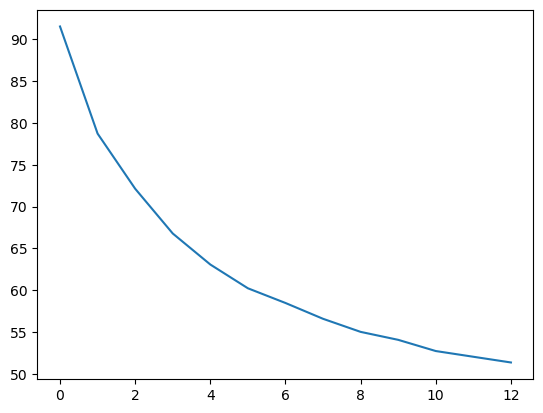

cost went down: 51.35696131297825
difference: 0.6837171570072584
iteration, index: 7000 615000


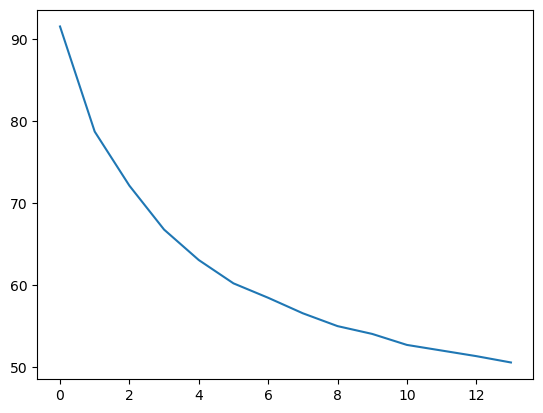

cost went down: 50.58351095778696
difference: 0.7734503551912866
iteration, index: 7500 376500


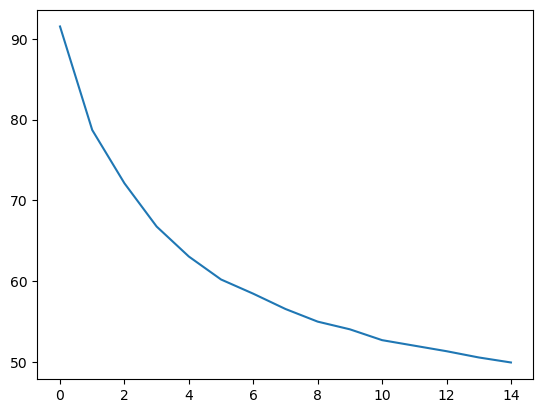

cost went down: 49.96203581492654
difference: 0.6214751428604259
iteration, index: 8000 138000


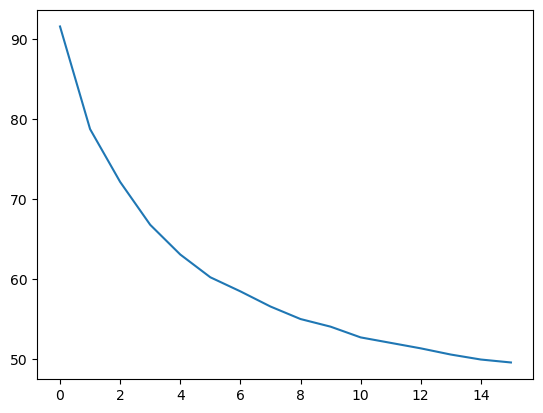

cost went down: 49.59383797126282
difference: 0.3681978436637152
iteration, index: 8500 888000


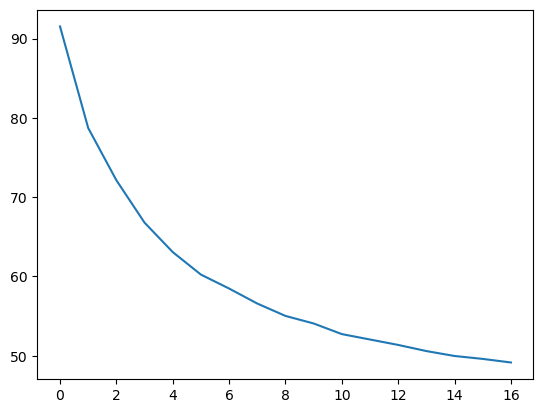

cost went down: 49.144061236454775
difference: 0.44977673480804725
iteration, index: 9000 649500


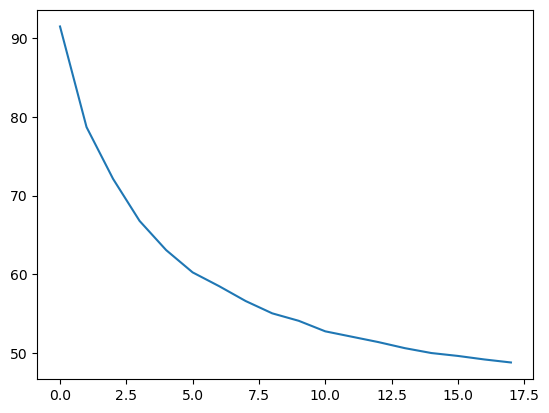

cost went down: 48.75996132464919
difference: 0.3840999118055848
iteration, index: 9500 411000


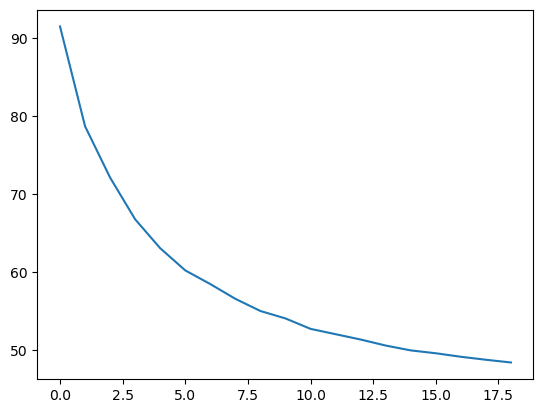

cost went down: 48.41099891704381
difference: 0.3489624076053772
iteration, index: 10000 172500


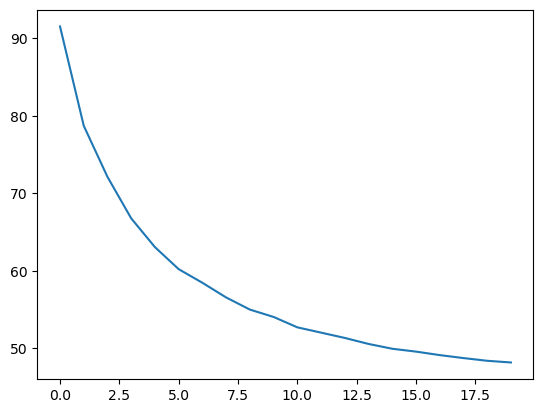

cost went down: 48.19242164091504
difference: 0.21857727612876943
iteration, index: 10500 922500


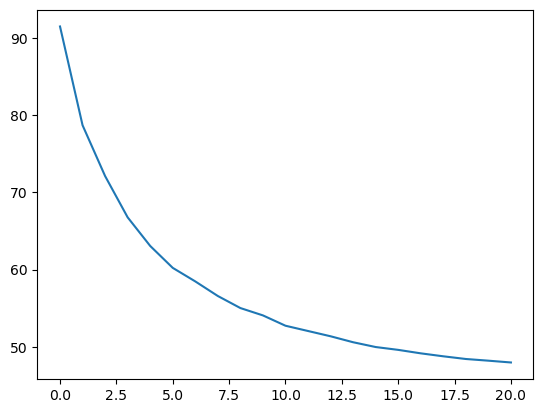

cost went down: 47.959154281250456
difference: 0.23326735966458756
iteration, index: 11000 684000


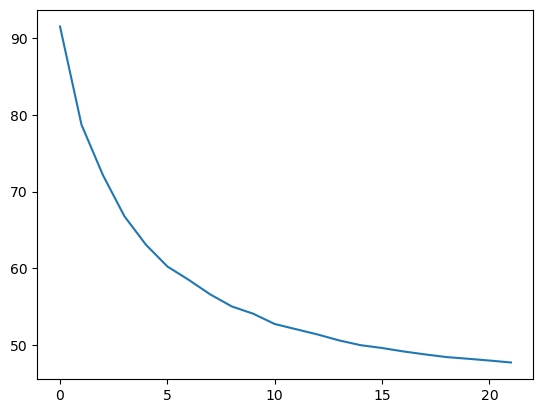

cost went down: 47.70696716251804
difference: 0.25218711873241517
iteration, index: 11500 445500


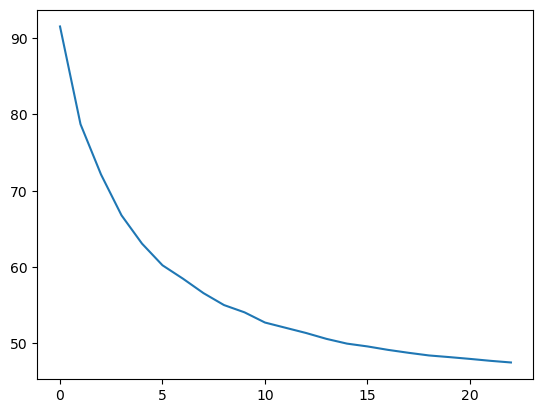

cost went down: 47.48983259745566
difference: 0.2171345650623806
iteration, index: 12000 207000


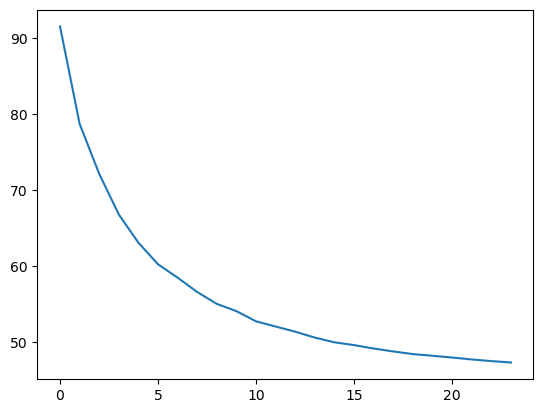

cost went down: 47.30857039245344
difference: 0.1812622050022199
iteration, index: 12500 957000


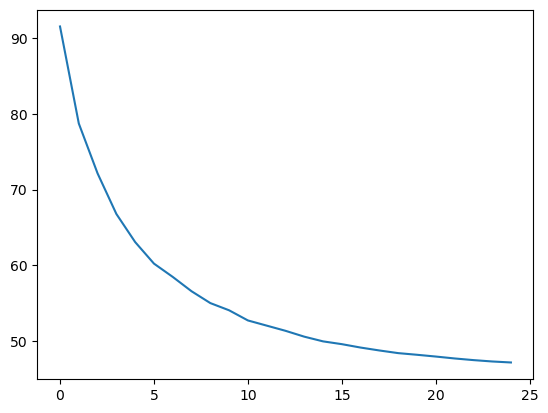

cost went down: 47.175934861067894
difference: 0.13263553138554585
iteration, index: 13000 718500


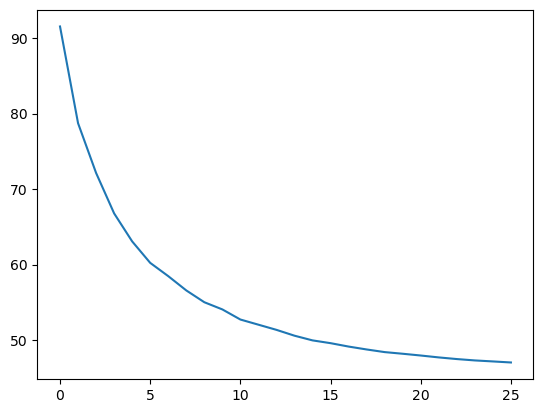

cost went down: 47.037329263277144
difference: 0.13860559779075032
iteration, index: 13500 480000


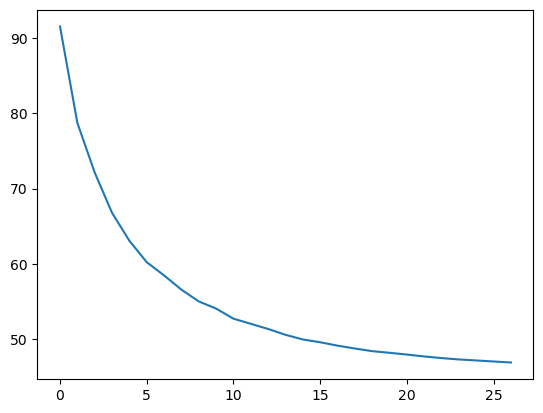

cost went down: 46.90705185711455
difference: 0.1302774061625911
iteration, index: 14000 241500


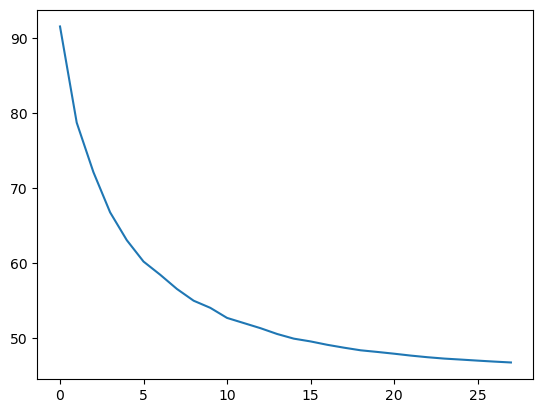

cost went down: 46.789245821793365
difference: 0.11780603532118761
iteration, index: 14500 3000


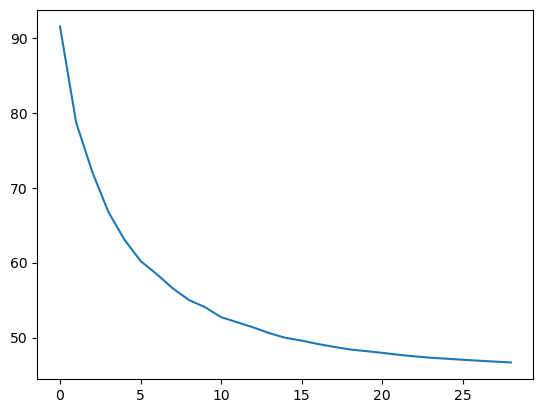

cost went down: 46.67205846068062
difference: 0.11718736111274808
iteration, index: 15000 753000


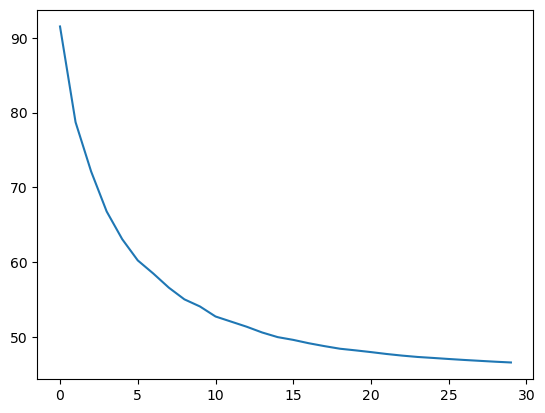

cost went down: 46.57027787682597
difference: 0.10178058385464794
iteration, index: 15500 514500


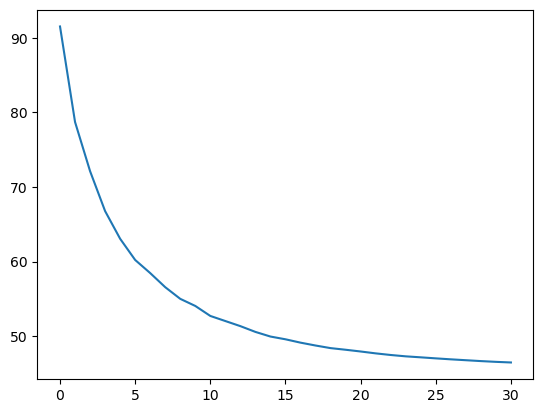

cost went down: 46.48601280386157
difference: 0.08426507296439922
iteration, index: 16000 276000


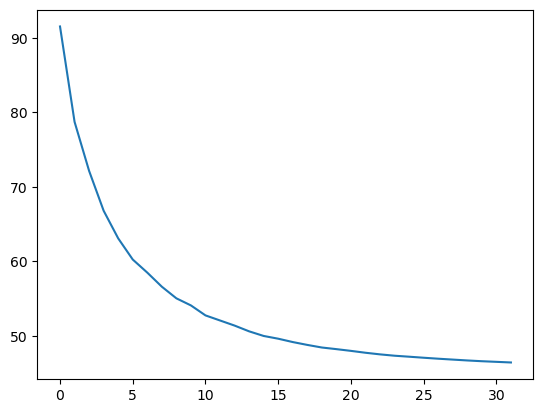

cost went down: 46.40074671479047
difference: 0.0852660890710979
iteration, index: 16500 37500


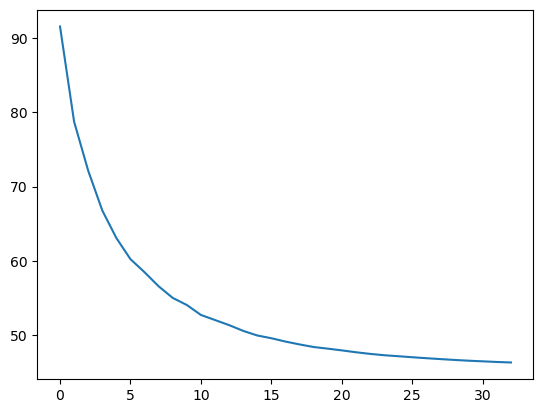

cost went down: 46.33238892033271
difference: 0.06835779445776069
iteration, index: 17000 787500


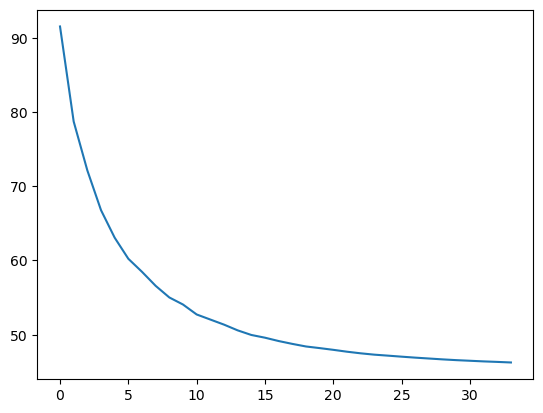

cost went down: 46.25512586377341
difference: 0.07726305655930332
iteration, index: 17500 549000


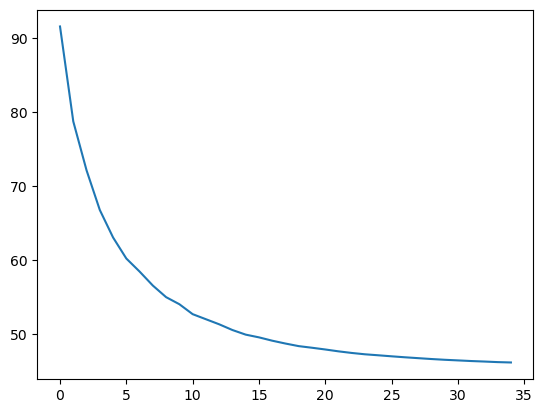

cost went down: 46.20588735872106
difference: 0.049238505052350945
iteration, index: 18000 310500


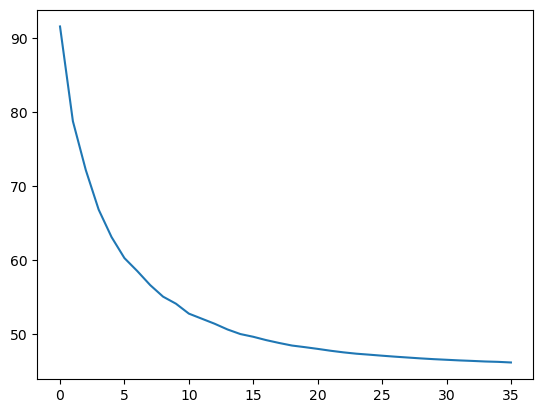

cost went down: 46.12142328462049
difference: 0.08446407410056622
iteration, index: 18500 72000


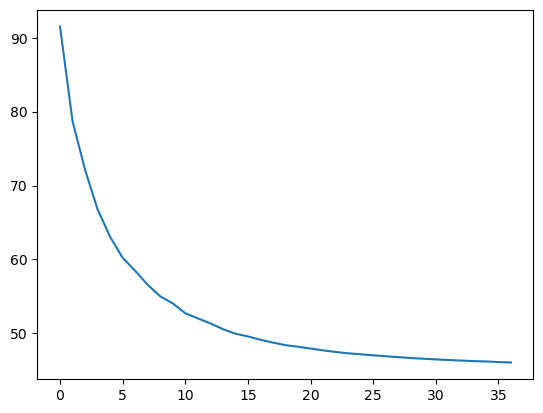

cost went down: 46.06728598788316
difference: 0.05413729673733059
iteration, index: 19000 822000


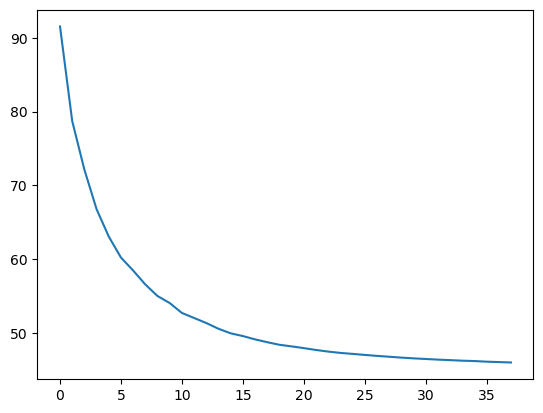

cost went down: 46.01217022587183
difference: 0.05511576201133295
iteration, index: 19500 583500


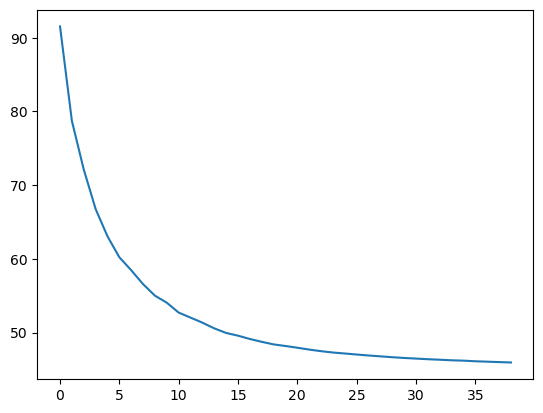

cost went down: 45.9583132958686
difference: 0.05385693000322789
iteration, index: 20000 345000


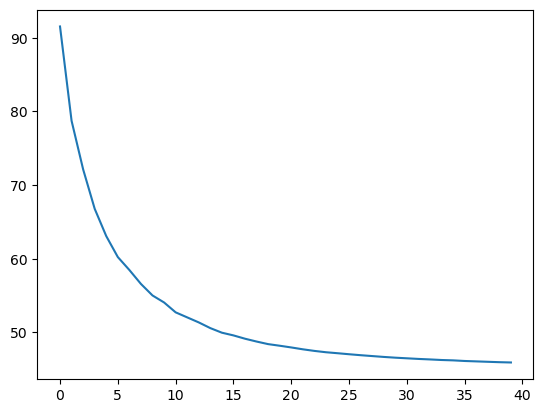

cost went down: 45.918938144520595
difference: 0.03937515134800407
iteration, index: 20500 106500


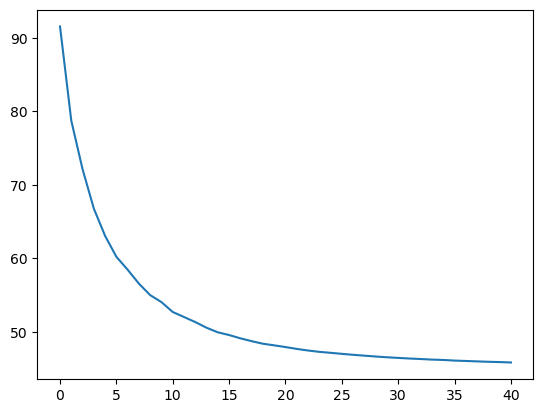

cost went down: 45.8635310441866
difference: 0.05540710033399421
iteration, index: 21000 856500


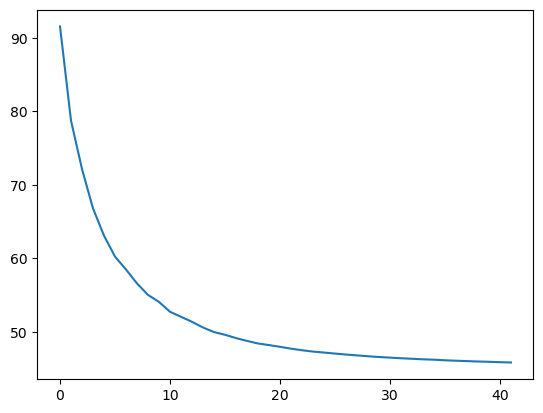

cost went down: 45.82600120524113
difference: 0.037529838945474125
iteration, index: 21500 618000


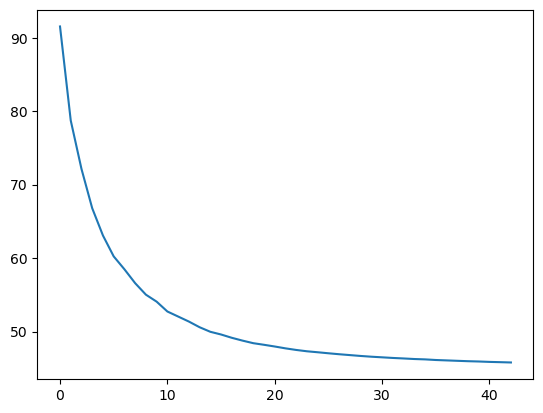

cost went down: 45.784580018515456
difference: 0.04142118672567108
iteration, index: 22000 379500


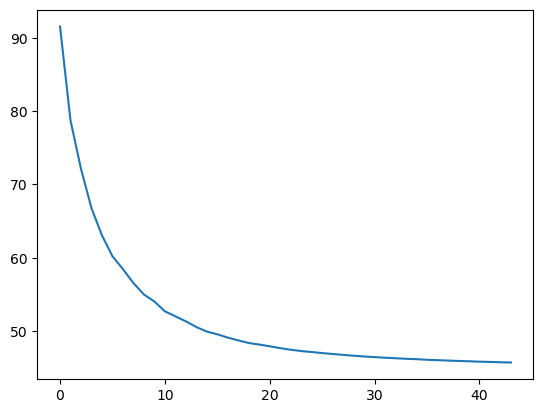

cost went down: 45.75353253042727
difference: 0.03104748808818414
iteration, index: 22500 141000


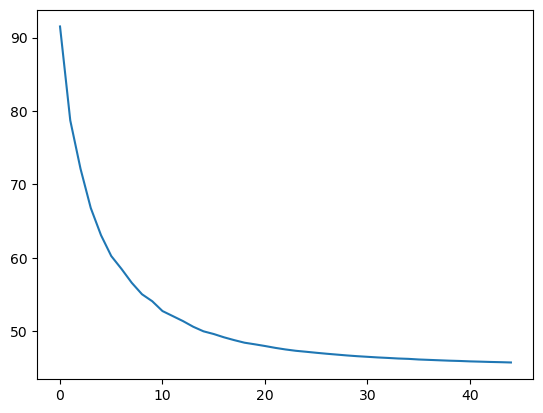

cost went down: 45.713413352288065
difference: 0.04011917813920718
iteration, index: 23000 891000


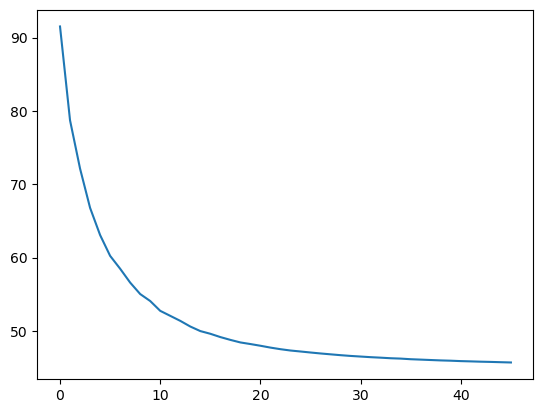

cost went down: 45.676897329013464
difference: 0.036516023274600684
iteration, index: 23500 652500


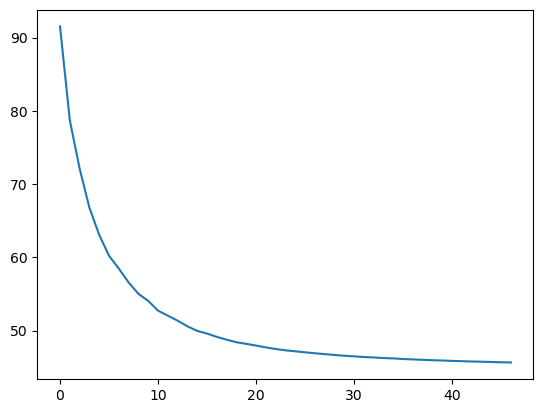

cost went down: 45.6492012101606
difference: 0.027696118852865936
iteration, index: 24000 414000


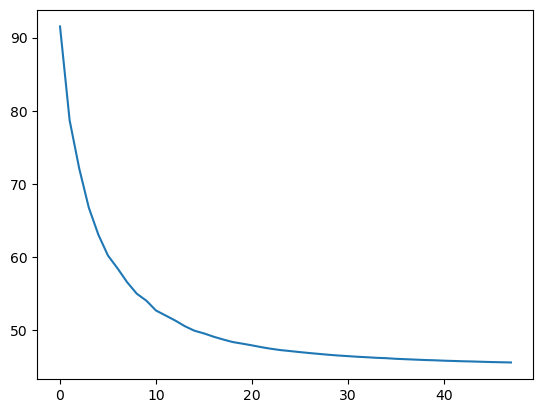

cost went down: 45.61875227716788
difference: 0.030448932992719335
iteration, index: 24500 175500


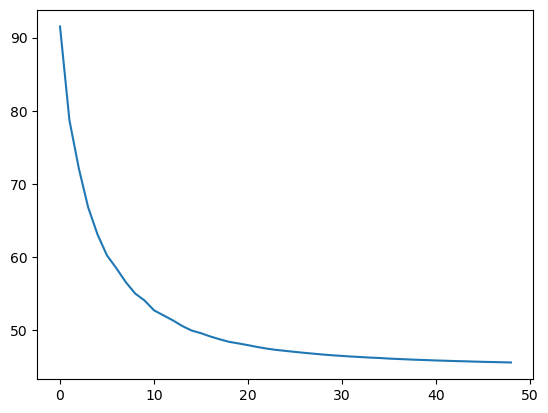

cost went down: 45.589209687257735
difference: 0.029542589910143136
iteration, index: 25000 925500


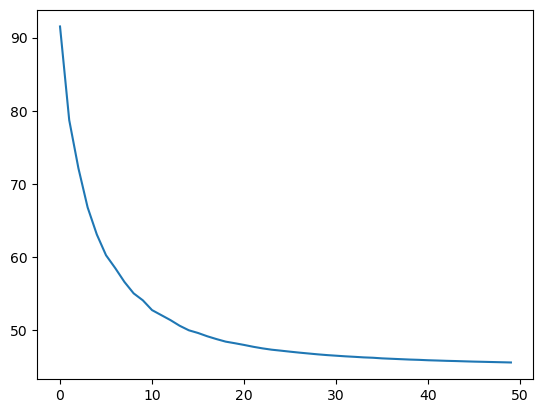

cost went down: 45.55898331854654
difference: 0.030226368711197438
iteration, index: 25500 687000


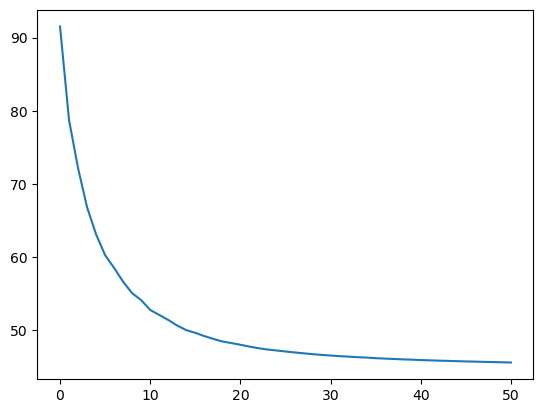

cost went down: 45.533221736943204
difference: 0.02576158160333364
iteration, index: 26000 448500


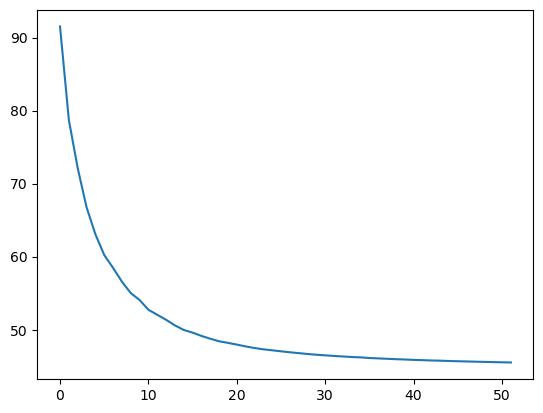

cost went down: 45.508537958867
difference: 0.024683778076202145
iteration, index: 26500 210000


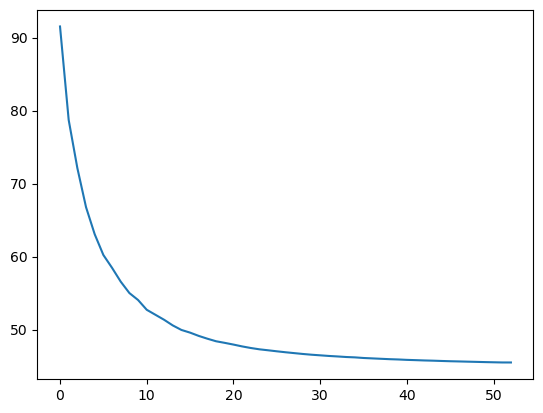

cost went down: 45.50636621682982
difference: 0.0021717420371842877
iteration, index: 27000 960000


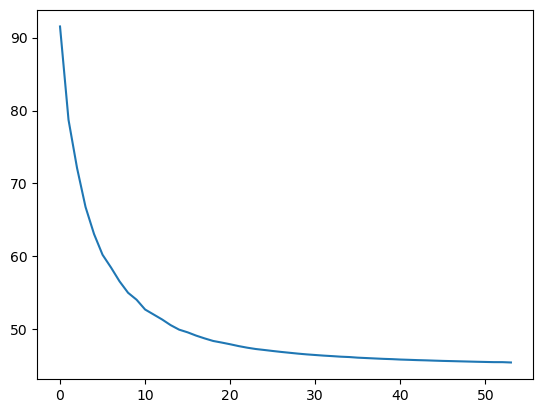

cost went down: 45.46133988347644
difference: 0.04502633335337691
iteration, index: 27500 721500


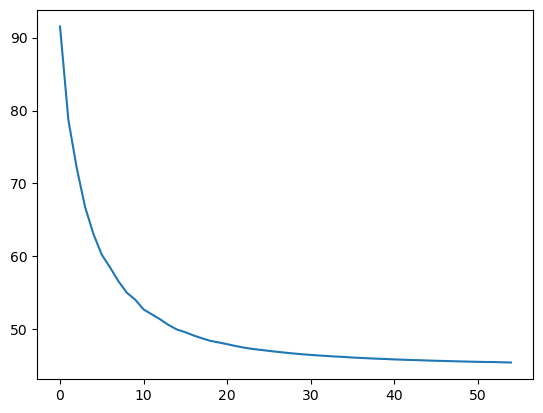

cost went down: 45.443415689681956
difference: 0.017924193794485177
iteration, index: 28000 483000


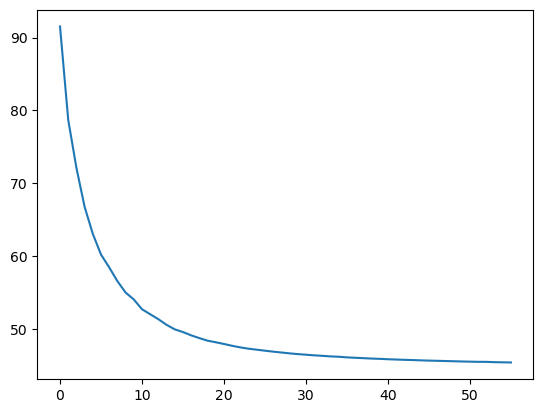

cost went down: 45.42070628089124
difference: 0.02270940879071759
iteration, index: 28500 244500


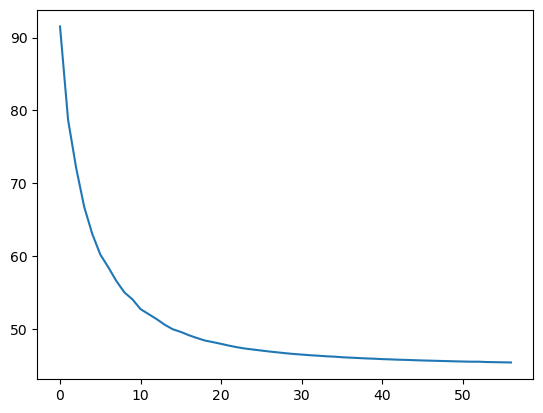

cost went down: 45.40038315838654
difference: 0.020323122504699143
iteration, index: 29000 6000


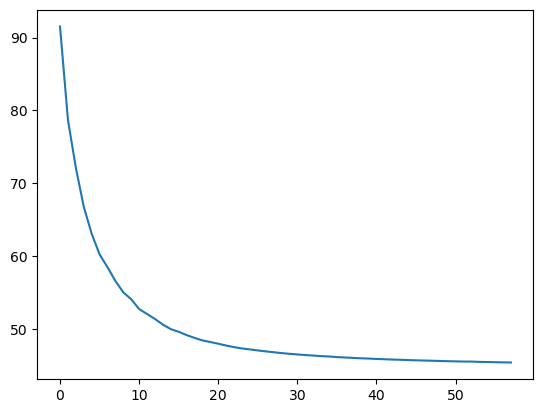

cost went down: 45.38162319822439
difference: 0.01875996016214998
iteration, index: 29500 756000


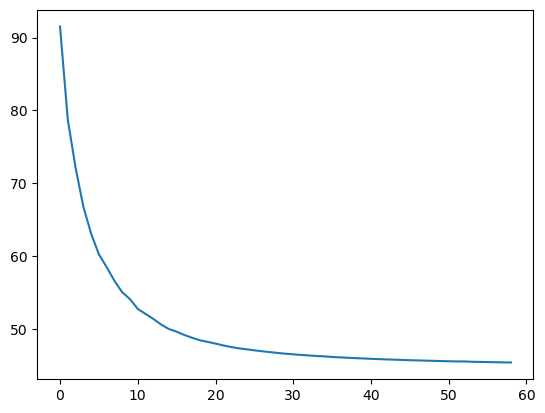

cost went down: 45.364998084543174
difference: 0.016625113681214998
iteration, index: 30000 517500


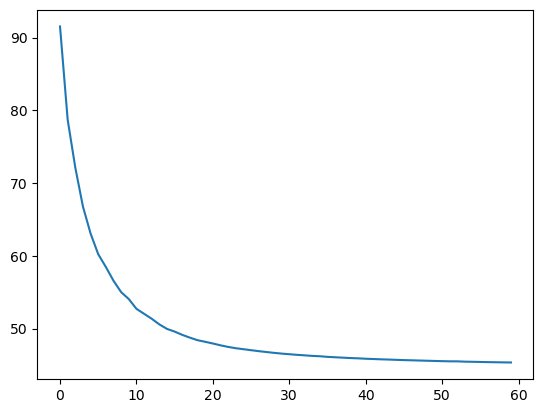

cost went down: 45.35052527045282
difference: 0.014472814090353836
iteration, index: 30500 279000


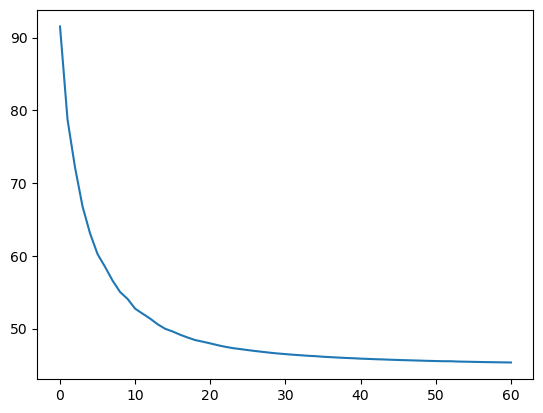

cost went down: 45.33570079176895
difference: 0.014824478683870268
iteration, index: 31000 40500


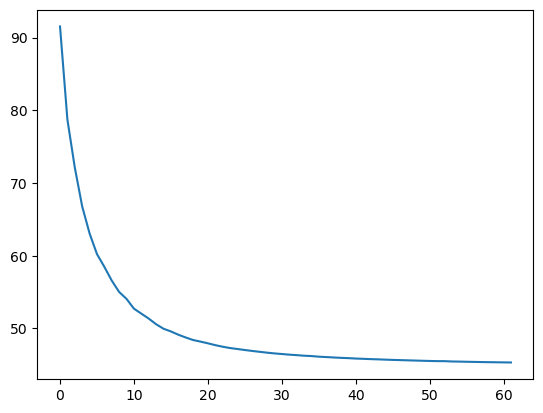

cost went down: 45.322668221895206
difference: 0.013032569873743682
iteration, index: 31500 790500


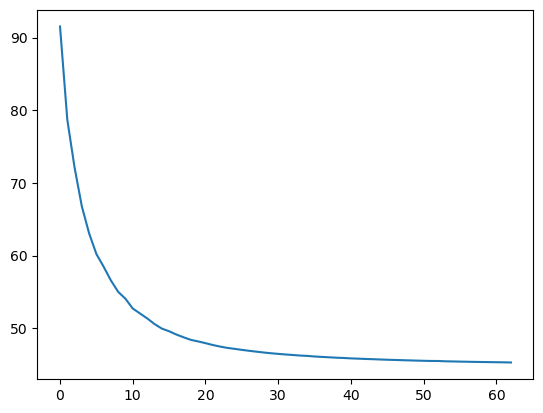

cost went down: 45.30053255020558
difference: 0.02213567168962527
iteration, index: 32000 552000


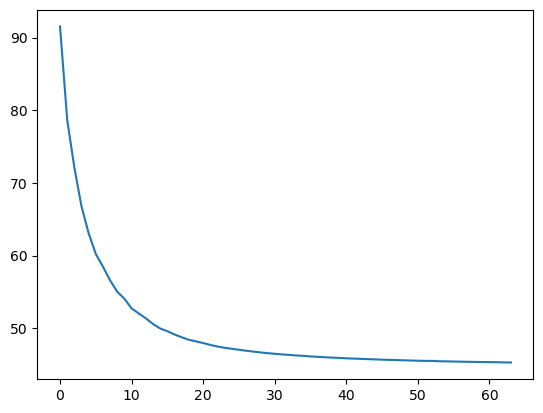

cost went down: 45.28958498418861
difference: 0.010947566016973553
iteration, index: 32500 313500


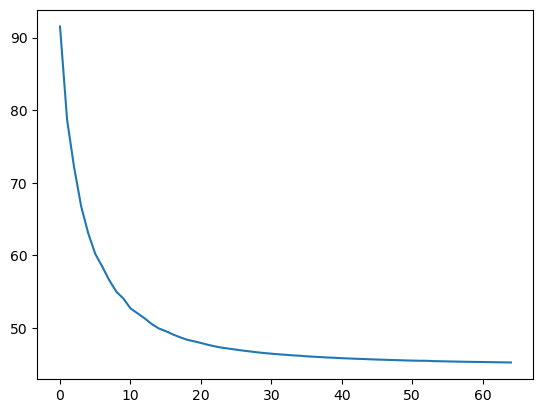

cost went down: 45.27398884505875
difference: 0.015596139129854691
iteration, index: 33000 75000


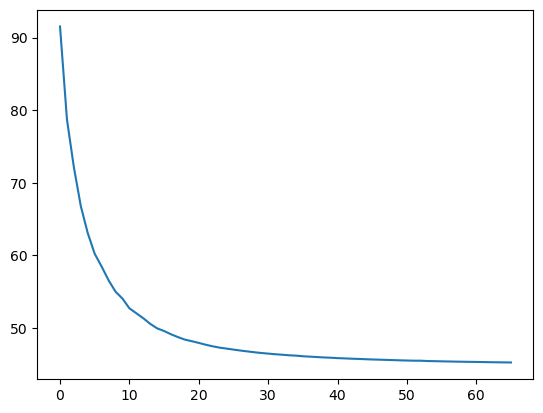

cost went down: 45.262939033613186
difference: 0.011049811445566604
iteration, index: 33500 825000


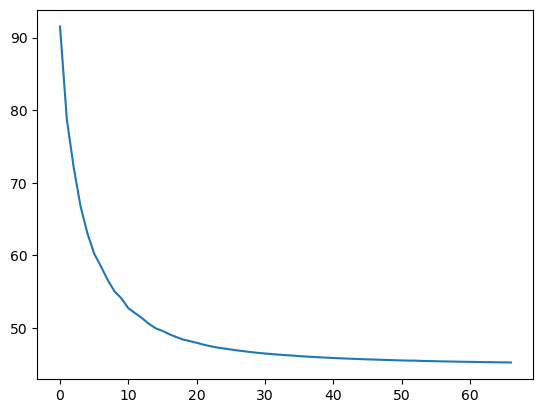

cost went down: 45.24945927421525
difference: 0.013479759397938551
iteration, index: 34000 586500


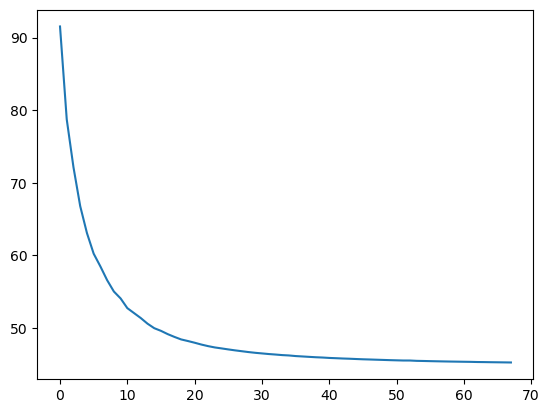

cost went down: 45.237094006036564
difference: 0.012365268178683664
iteration, index: 34500 348000


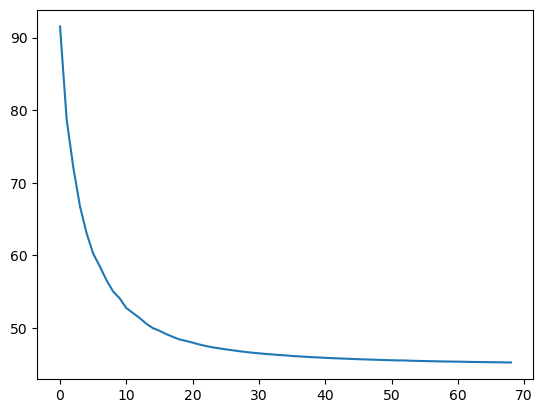

cost went down: 45.22538680045193
difference: 0.011707205584635005
iteration, index: 35000 109500


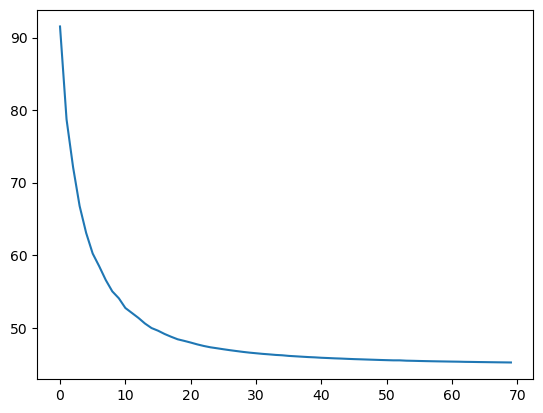

cost went down: 45.21394692198467
difference: 0.011439878467257358
iteration, index: 35500 859500


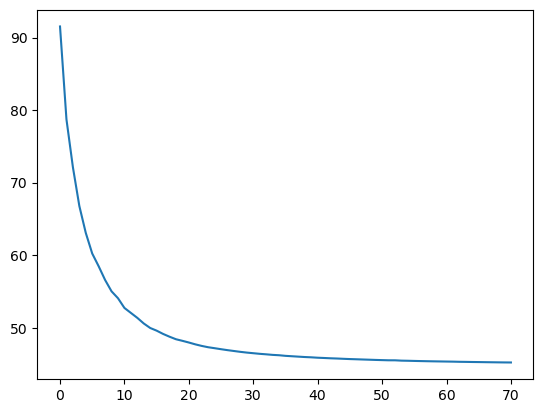

cost went down: 45.20759650851007
difference: 0.006350413474599748
iteration, index: 36000 621000


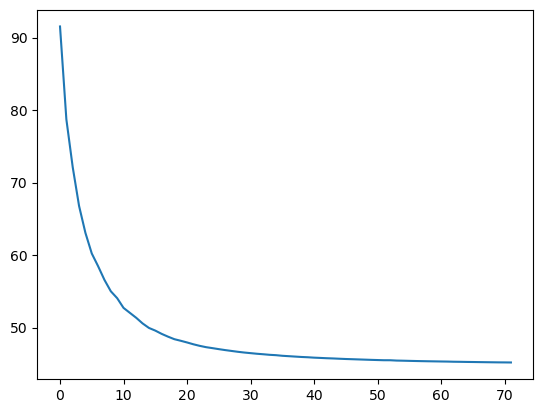

cost went down: 45.19836113791582
difference: 0.009235370594254277
iteration, index: 36500 382500


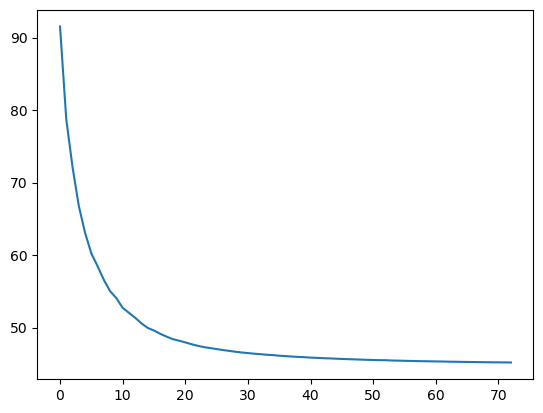

cost went down: 45.189806453731485
difference: 0.008554684184332473
iteration, index: 37000 144000


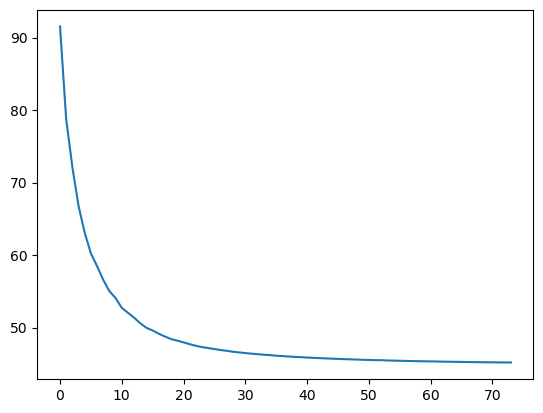

cost went down: 45.18680094260581
difference: 0.003005511125678595
iteration, index: 37500 894000


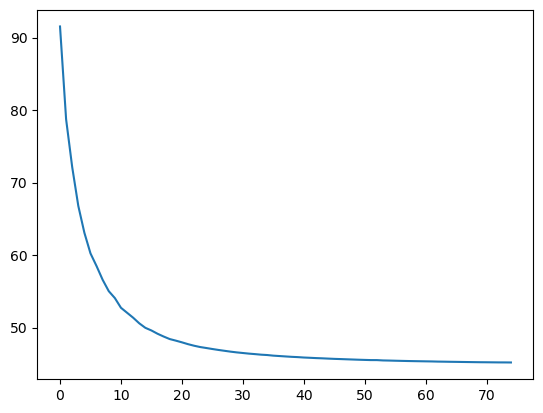

cost went down: 45.179055114784255
difference: 0.007745827821551643
iteration, index: 38000 655500


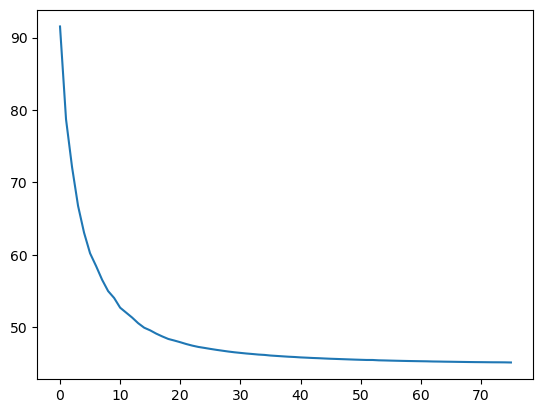

cost went down: 45.16292064867581
difference: 0.016134466108447043
iteration, index: 38500 417000


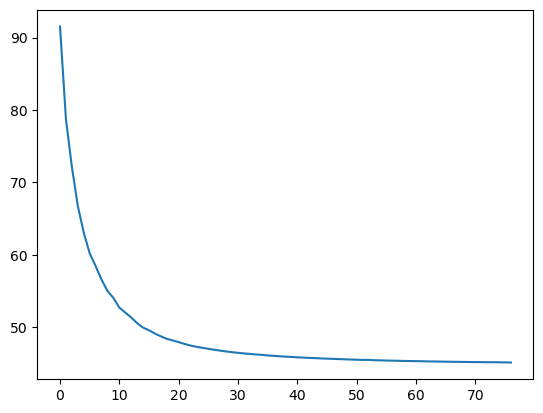

cost went down: 45.15151875989897
difference: 0.01140188877683812
iteration, index: 39000 178500


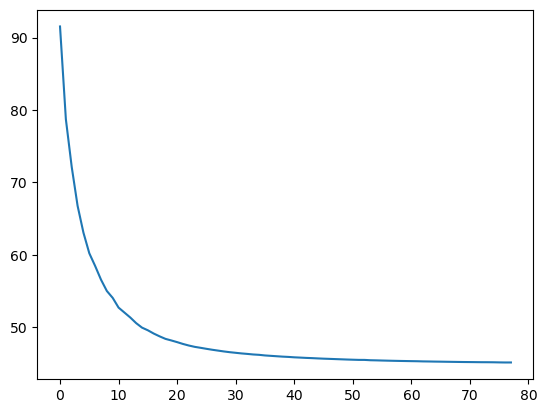

cost went UP: 45.15292804066194
difference: 0.001409280762970866
iteration, index: 39500 928500


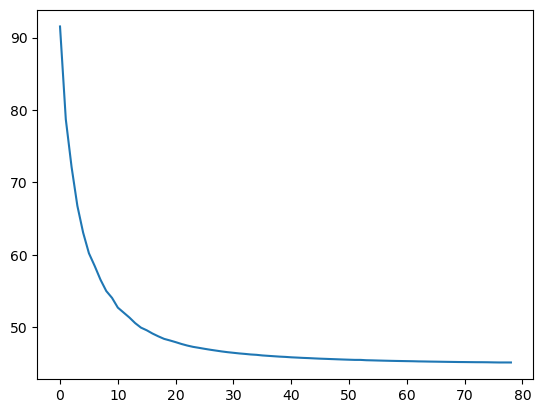

cost went down: 45.150867487498985
difference: 0.002060553162955614
iteration, index: 40000 690000


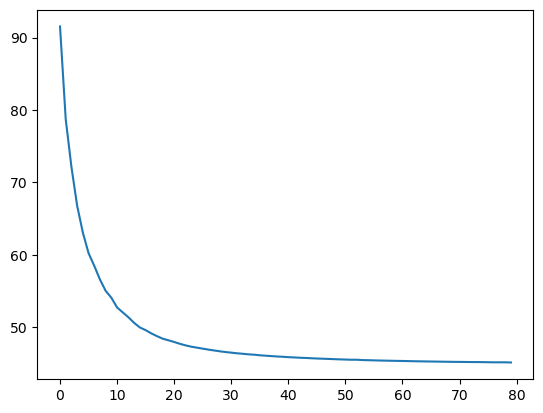

cost went down: 45.128929739043585
difference: 0.021937748455400197
iteration, index: 40500 451500


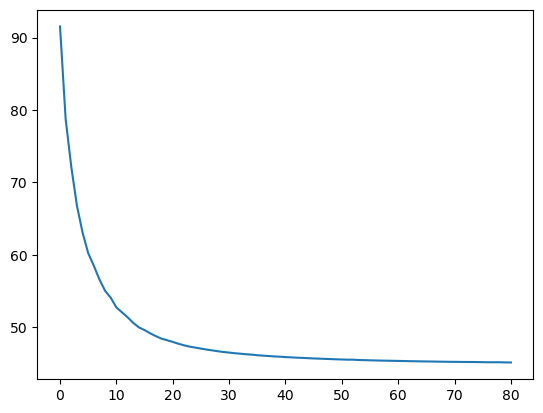

cost went down: 45.12025575859946
difference: 0.008673980444122265
iteration, index: 41000 213000


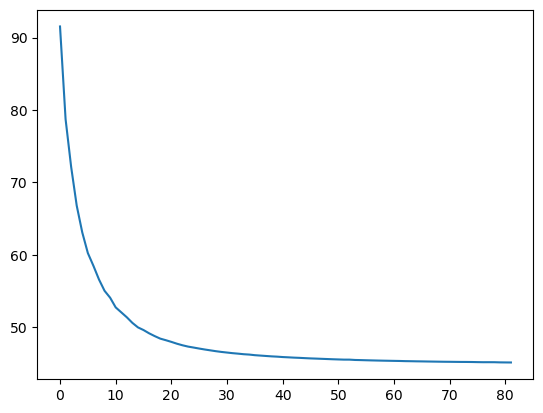

cost went down: 45.11424844501267
difference: 0.006007313586792407
iteration, index: 41500 963000


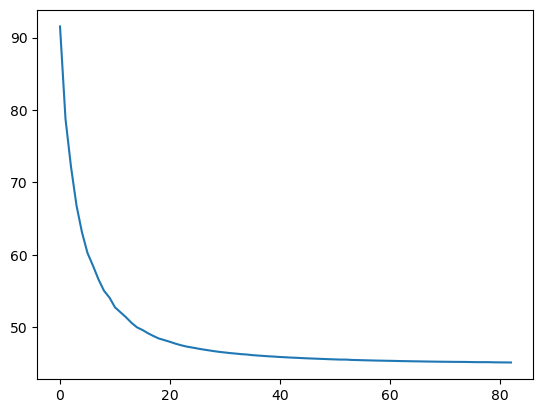

cost went down: 45.10794134449007
difference: 0.006307100522597864
iteration, index: 42000 724500


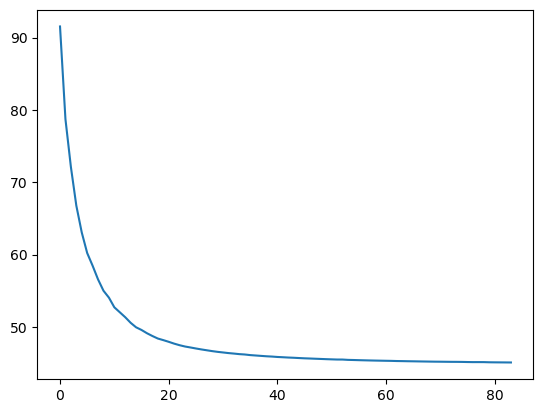

cost went down: 45.10164166303557
difference: 0.006299681454500217
iteration, index: 42500 486000


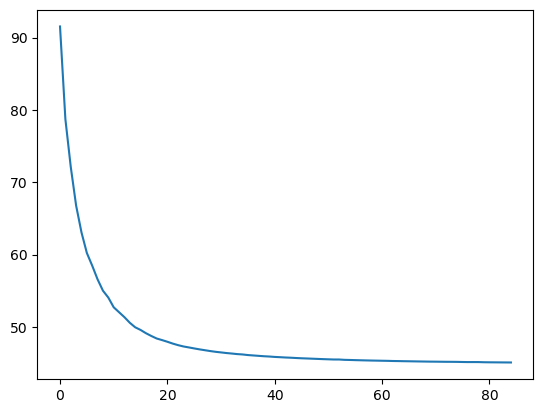

cost went down: 45.09659230956074
difference: 0.005049353474831264
iteration, index: 43000 247500


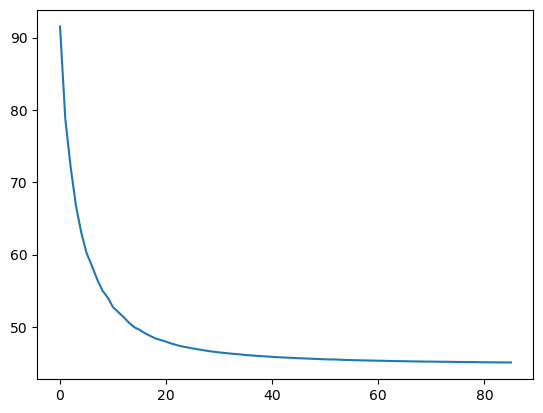

cost went down: 45.090474470032134
difference: 0.006117839528606339
iteration, index: 43500 9000


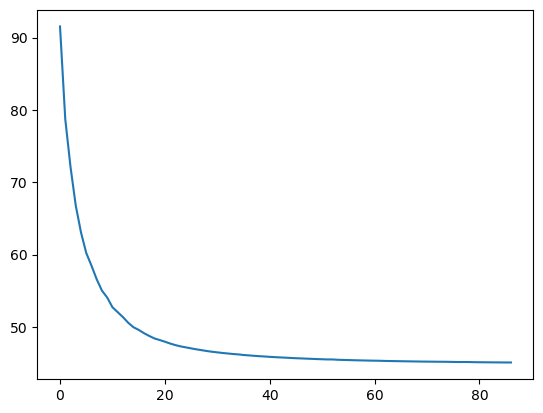

cost went down: 45.08812856305789
difference: 0.0023459069742415295
iteration, index: 44000 759000


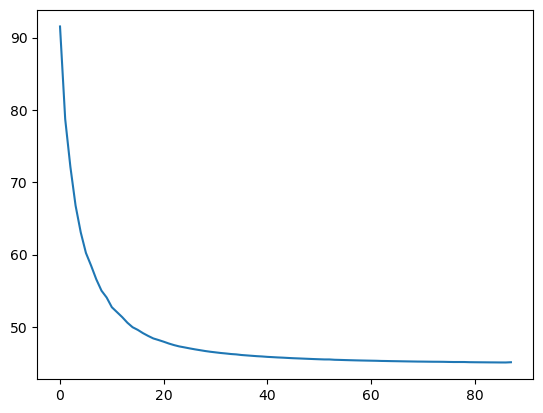

cost went UP: 45.121055060170015
difference: 0.03292649711212192
iteration, index: 44500 520500


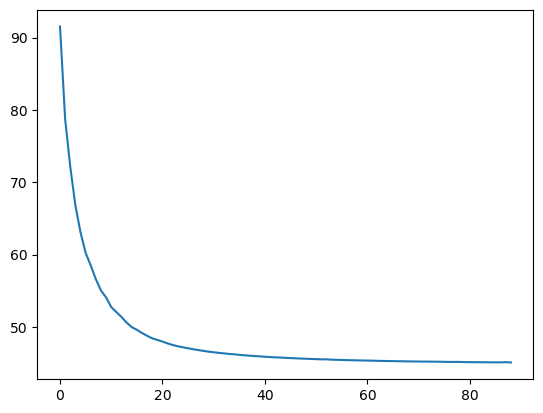

cost went down: 45.073880536882754
difference: 0.04717452328726068
iteration, index: 45000 282000


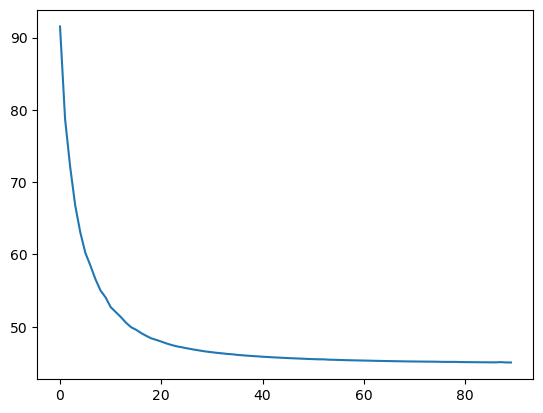

cost went down: 45.07087276885085
difference: 0.0030077680319067213
iteration, index: 45500 43500


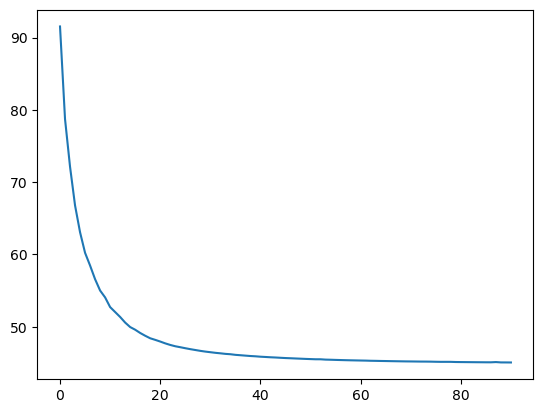

cost went down: 45.06468497502693
difference: 0.006187793823919208
iteration, index: 46000 793500


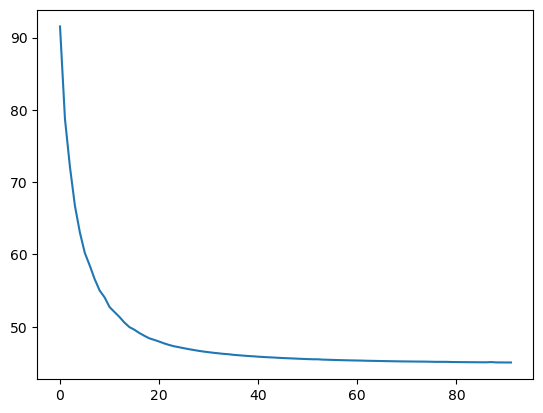

cost went UP: 45.06636380380769
difference: 0.001678828780761421
iteration, index: 46500 555000


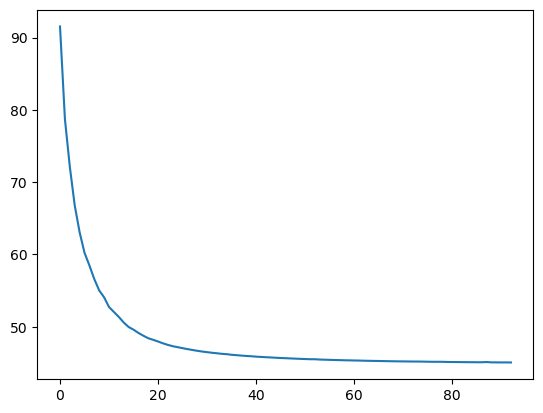

cost went down: 45.05773616263653
difference: 0.00862764117115944
iteration, index: 47000 316500


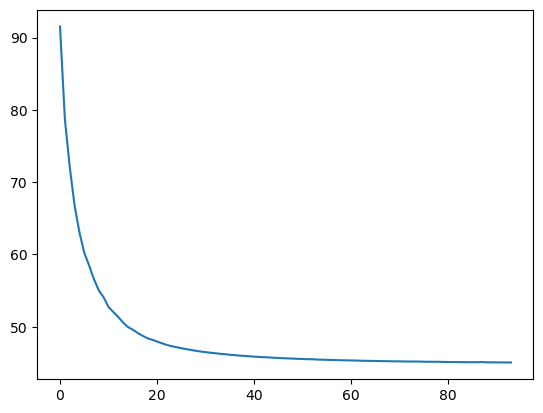

cost went down: 45.0545640410469
difference: 0.0031721215896283184
iteration, index: 47500 78000


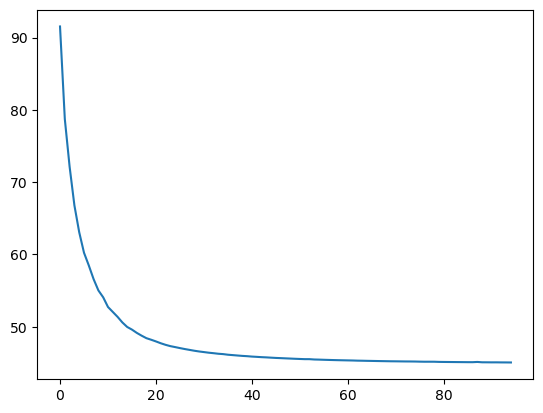

cost went down: 45.04789109458415
difference: 0.006672946462749962
iteration, index: 48000 828000


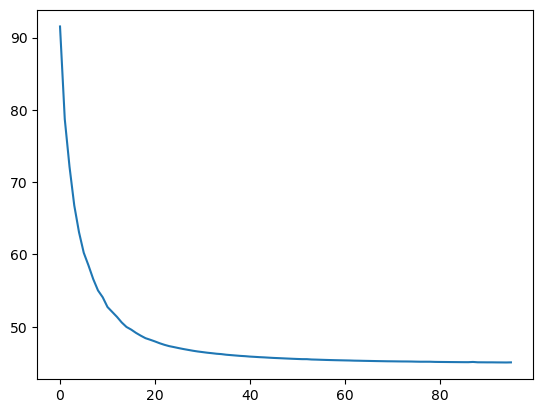

cost went UP: 45.06193725166483
difference: 0.014046157080677801
iteration, index: 48500 589500


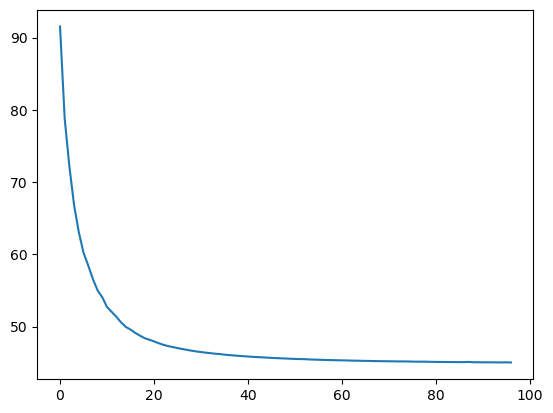

cost went down: 45.04089992399223
difference: 0.02103732767260169
iteration, index: 49000 351000


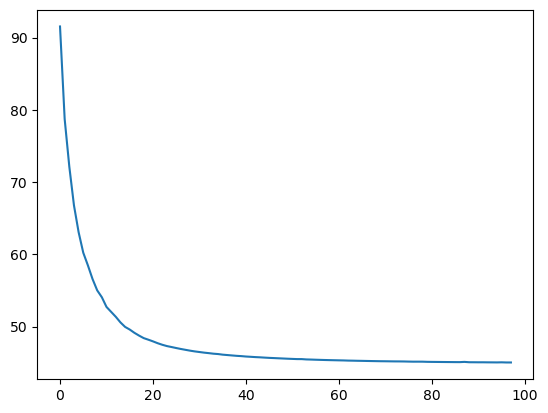

cost went down: 45.03997005494549
difference: 0.0009298690467360871


In [53]:
# initialize a model object and start training

X_train_np, y_train_np = X_train.to_numpy(), y_train.to_numpy()

model = Model(X_train_np, y_train_np, alpha=0.01, epsilon=0.001)

model.shuffle_dataset()
_ = model.train(model.mini_batch_gradient_descent)  # using mini-batch

### Decreasing Alpha (learning rate) and More Training
As our model learns, it's important to adjust the alpha value (learning rate). The learning rate is a controlling factor in our model's learning process, determining the size of the steps it takes towards the minimum of the cost function. An overly large alpha might cause the model to overshoot this minimum (by taking too large of a step past it), while a small alpha could result in an excessively long convergence time (tip toeing forever towards it).

In mini-batch gradient descent we can't reach an absolute minimum, because due to the fact that it's computing using a subset of the rows, each step will be a bit random. Due to this, our cost will oscillate the minimum. To combat this, we decrease the learning rate so that it takes smaller steps and as result will oscillate a smaller radius; closer to the absolute minimum.

![Gradient Descents vs Learning Rate Contour Plot Drawing](gradient_descent_contour_plot.JPG)

Now that we've sufficiently trained and converged (according to epsilon) at a higher alpha value, we'll pursue further training at a lower alpha in hopes that it might edge us even closer to the absolute minimum.

iteration, index: 500 750000


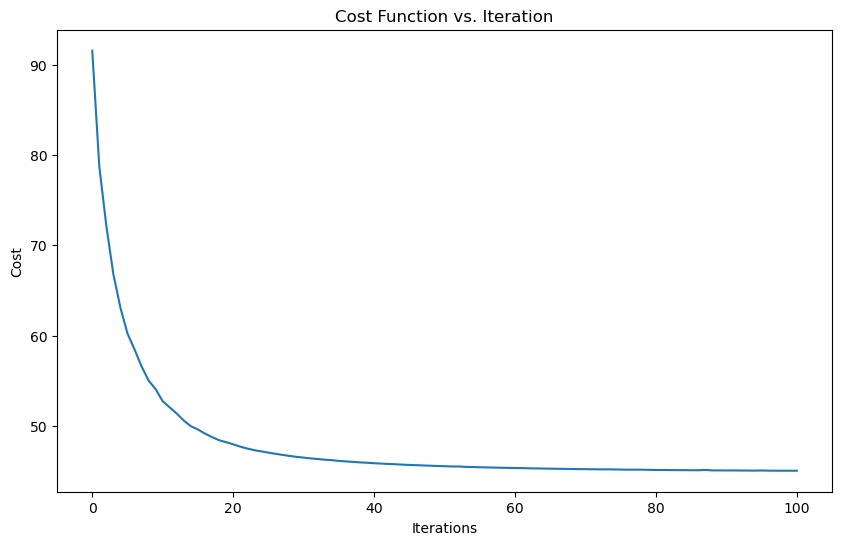

cost went down: 45.0356586023015
difference: 0.00031520594599498963
iteration, index: 1000 511500


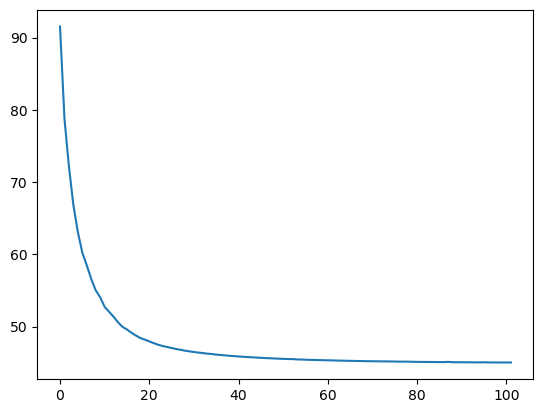

cost went down: 45.03542303895282
difference: 0.00023556334868146678
iteration, index: 1500 273000


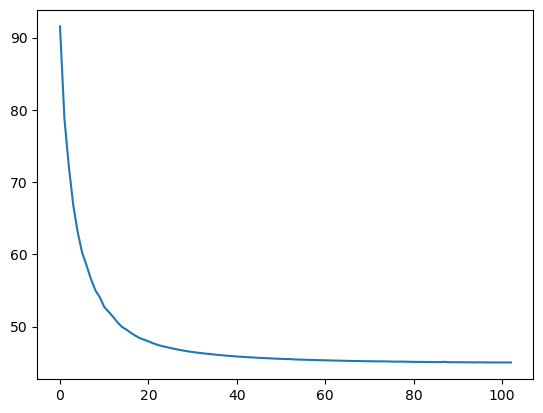

cost went down: 45.03524707704634
difference: 0.00017596190647850563
iteration, index: 2000 34500


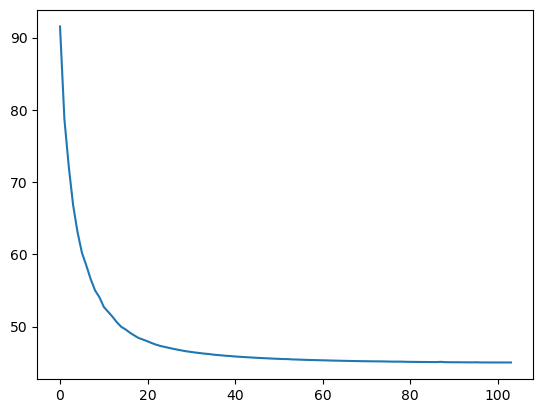

cost went down: 45.034805880055075
difference: 0.0004411969912681002
iteration, index: 2500 784500


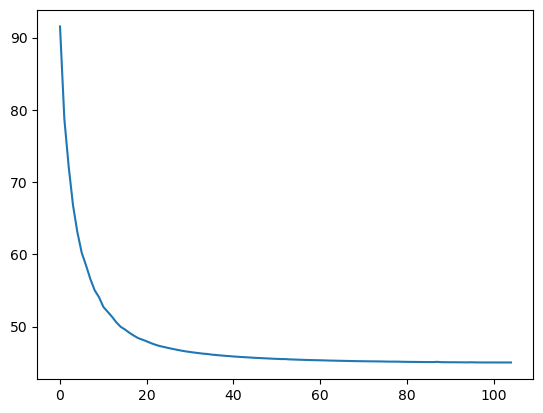

cost went down: 45.034688321146575
difference: 0.00011755890849940442
iteration, index: 3000 546000


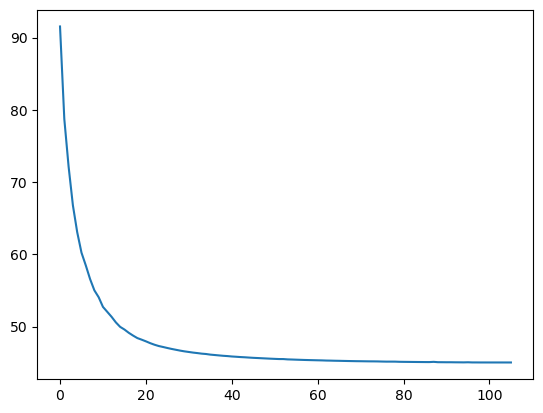

cost went down: 45.03398420457498
difference: 0.0007041165715975239
iteration, index: 3500 307500


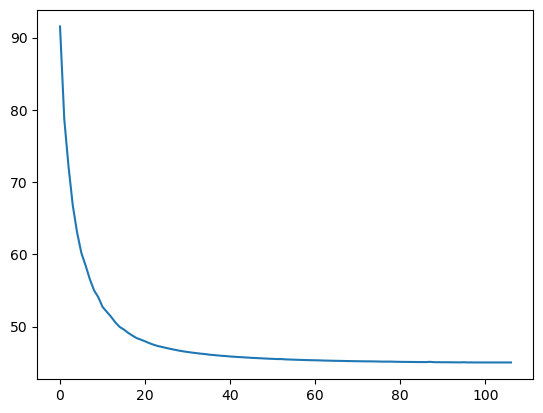

cost went down: 45.033611944621065
difference: 0.00037225995391310107
iteration, index: 4000 69000


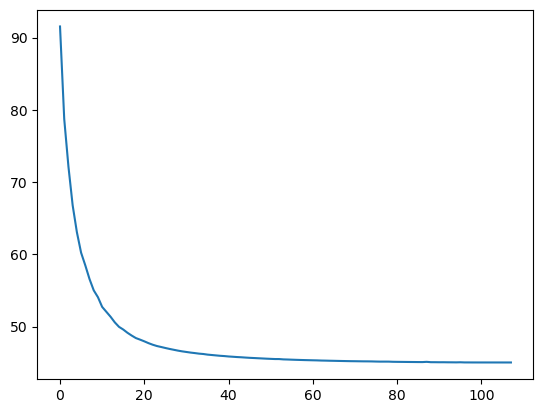

cost went down: 45.03331007021594
difference: 0.0003018744051246358
iteration, index: 4500 819000


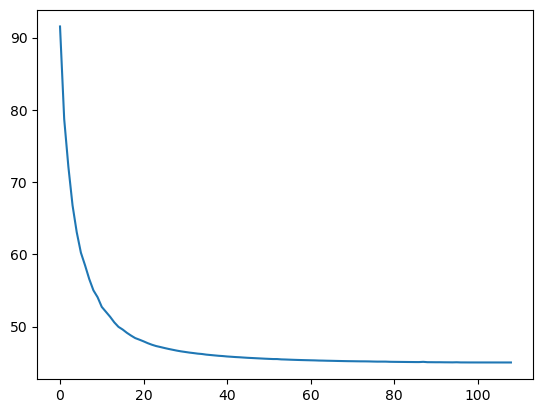

cost went down: 45.03293581275713
difference: 0.0003742574588088132
iteration, index: 5000 580500


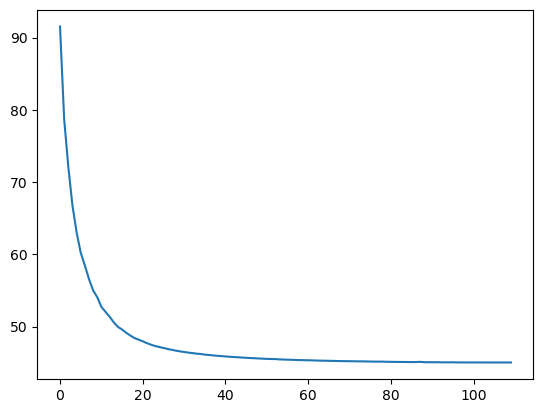

cost went down: 45.03263436252037
difference: 0.0003014502367619798
iteration, index: 5500 342000


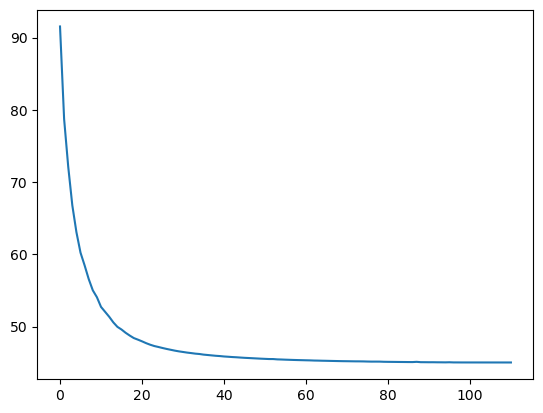

cost went down: 45.032443167313545
difference: 0.00019119520682409075
iteration, index: 6000 103500


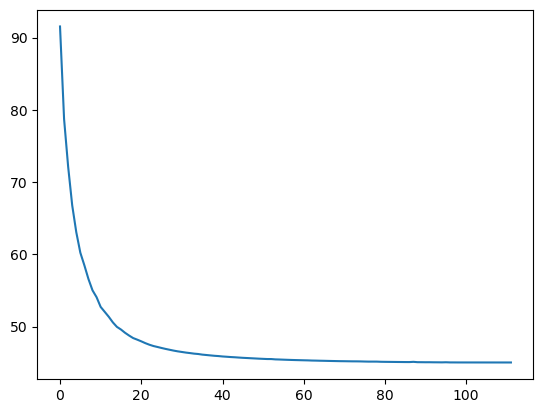

cost went down: 45.03239246094584
difference: 5.070636770199144e-05


In [57]:
# lower alpha to reduce the oscillation range and close in on the minimum, then continue training

# prev alpha: 0.01, prev epsilon: 0.001
model.alpha = 0.001
model.epsilon = 0.0001

_ = model.train(model.mini_batch_gradient_descent)

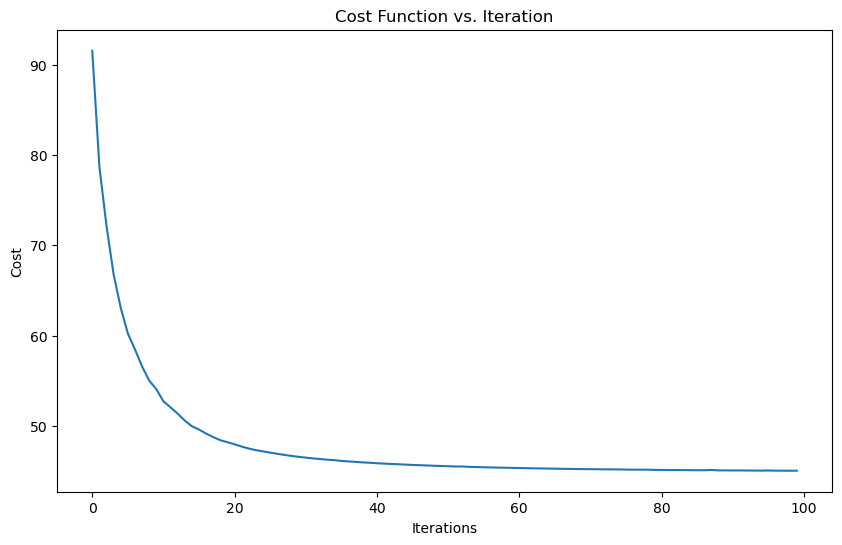

final cost: 45.0359738082475


In [55]:
# plot the final cost history
plt.figure(figsize=(10, 6))
plt.plot(model.cost_history)
plt.title('Cost Function vs. Iteration')
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.show()

print('final cost:', model.cost_history[-1])

## Model Evaluation
We've finally trained our model! We now move to the evaluation stage, where we assess how well our model performs. We will use the test data (kept separate from the training data to prevent information leakage) to evaluate the model's predictive performance.

The metric we'll use is the **Root Mean Squared Error (RMSE)**, which calculates the average squared difference between the model's predictions and the actual values. It's a popular metric for regression models because it penalizes larger errors more due to squaring each difference. Our aim is to have the lowest RMSE possible, which would indicate that our model's predictions closely match the actual values.

However, it's important to remember that no model is perfect; this is especially true when it's an engineer's first-ever model, and doubly so when built entirely from scratch! It's this exciting journey of constant growth and improvement that truly embodies the spirit of machine learning.

In [56]:
X_test_np, y_test_np = X_test.to_numpy(), y_test.to_numpy()

# generate predictions for every training example in the testing set
y_predicted = np.array([model.predict(x_row) for x_row in X_test_np])
y_actual = y_test.to_numpy()

# root mean squared error of the model
rmse = mean_squared_error(y_actual, y_predicted, squared=False)

# printing the parameters' final values and the error they produce
print(f'bias parameter (theta 0): {model.theta_0}\nweights parameters (theta vector): {model.theta_vector}')
print('Root Mean Squared Error:', rmse)

y_test.describe()

bias parameter (theta 0): 0.6638866705693053
weights parameters (theta vector): [-0.1950215  -0.21778255 -0.04735735  0.01070294  0.19123685  0.11586946
  0.03743055  0.02385733]
Root Mean Squared Error: 9.571722853963104


count    300250.000000
mean         11.367405
std           9.442485
min           3.300000
25%           6.000000
50%           8.500000
75%          12.500000
max         100.000000
Name: fare_amount, dtype: float64

## Results and Conclusion
We have journeyed from data wrangling, exploratory data analysis, feature engineering, to the nitty-gritty of building and training of our model. At each stage, we’ve learned something new and faced exciting challenges.

Now, let's look at the model's performance. When I ran the notebook, my model yielded these parameters:
- bias parameter (theta 0): 0.6638866705693053  
- weights parameters (theta vector): [-0.1950215  -0.21778255 -0.04735735  0.01070294  0.19123685  0.11586946 0.03743055  0.02385733]

Our model registered a **Root Mean Squared Error (RMSE)** score of 9.57 on the test data (rounded to two decimal places). RMSE is a standard way to measure the error of a model in predicting quantitative data. It indicates the standard deviation of the residuals or prediction errors. To put this into context, given that our target variable is 'fare_amount', an RMSE of 9.57 means that our model's predicted taxi fares tend to deviate from the actual fares by approximately $9.57 dollars.

Reflecting on this, it's clear that while our model has room for improvement, it represents a promising start. What's particularly impressive is that it's the first model I've ever built and was created entirely from scratch! As we move forward, we could experiment with different algorithms, additional feature engineering, and hyperparameter tuning to enhance our model's performance.

Ultimately, this project served as an invaluable hands-on experience in the field of machine learning. It has shown that model-building in machine learning is a delicate balance of managing complexity, understanding data, and cultivating an intuitive sense. This sense, which matures over time, is key for making strategic decisions on methodologies and for navigating model development effectively.

As we conclude this project, we are reminded that in the world of machine learning, every end is simply a new beginning, setting the stage for further learning and exploration. Here's to many more fascinating projects ahead!